# 1.基于方差的特征选择

In [52]:
df = pd.read_csv("Dataset\\test.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
feature_name = df.iloc[:, 1:-1]
from sklearn.feature_selection import VarianceThreshold
# 利用sklearn包进行方差选择
vt = VarianceThreshold(threshold=0.01)
x = vt.fit_transform(x)
print(f'x的形状为：{x.shape}')
removed_features = ~vt.get_support()

# 输出被剔除的特征
for feature_idx, feature_status in enumerate(removed_features):
    if feature_status:
        print(f"Feature“{feature_name.columns[feature_idx]}”is removed.")

x的形状为：(13611, 6)
Feature“Eccentricity”is removed.
Feature“Extent”is removed.
Feature“Solidity”is removed.
Feature“roundness”is removed.
Feature“Compactness”is removed.
Feature“ShapeFactor1”is removed.
Feature“ShapeFactor2”is removed.
Feature“ShapeFactor3”is removed.
Feature“ShapeFactor4”is removed.


In [85]:
df = pd.read_csv("Dataset\\test.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
columns_to_drop = ['Eccentricity','Extent','Solidity','roundness','Compactness','ShapeFactor1','ShapeFactor2','ShapeFactor3','ShapeFactor4']
df_dropped = x.drop(columns=columns_to_drop)
x = df_dropped
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1],1))
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.values.reshape(len(y_train), 1))
y_test = onehot.fit_transform(y_test.values.reshape(len(y_test), 1))
print(f'训练集的形状为：{x_train.shape}')

训练集的形状为：(19857, 6, 1)


In [86]:
inp=Input(shape=(x_train.shape[1:]))
x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)

lstm1=LSTM(units=32,activation='tanh',return_sequences=True)(inp)
l=Dropout(0.5)(lstm1)
l=LSTM(units=64,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
l=LSTM(units=128,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
d = Flatten()(l)

g2=concatenate([g,d],axis=1)
q = Dense(128)(g2)
q = LeakyReLU(alpha=0.33)(q)
q = Dense(256, activation="tanh")(q)
output = Dense(7, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(q)
model = Model(inputs=inp,outputs=output)

In [87]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),  #优化器
              loss = 'categorical_crossentropy', #损失函数
              metrics = ['accuracy']
             )
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.5,min_lr=0.000001)
start = time.perf_counter()
history = model.fit(x_train,
                    y_train,
                    epochs=40,
                    callbacks = [lr_reduce],
                    batch_size= 32,
                    validation_data = (x_test,y_test),
                    shuffle=True)
end = time.perf_counter()
print(model.evaluate(x_test,y_test))
print('Running time: %s Seconds'%(end-start))
Y_test = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
predict = model.predict(x_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,digits=5))

Epoch 1/40
621/621 [==============================] - 17s 21ms/step - loss: 1.7826 - accuracy: 0.2946 - val_loss: 1.1773 - val_accuracy: 0.4709
Epoch 2/40
621/621 [==============================] - 12s 20ms/step - loss: 0.9643 - accuracy: 0.5807 - val_loss: 0.5012 - val_accuracy: 0.8032
Epoch 3/40
621/621 [==============================] - 12s 20ms/step - loss: 0.5916 - accuracy: 0.7758 - val_loss: 0.4015 - val_accuracy: 0.8528
Epoch 4/40
621/621 [==============================] - 13s 20ms/step - loss: 0.5144 - accuracy: 0.8056 - val_loss: 0.4103 - val_accuracy: 0.8409
Epoch 5/40
621/621 [==============================] - 12s 20ms/step - loss: 0.5053 - accuracy: 0.8089 - val_loss: 0.4149 - val_accuracy: 0.8417
Epoch 6/40
621/621 [==============================] - 13s 21ms/step - loss: 0.4610 - accuracy: 0.8235 - val_loss: 0.3642 - val_accuracy: 0.8653
Epoch 7/40
621/621 [==============================] - 13s 20ms/step - loss: 0.4668 - accuracy: 0.8186 - val_loss: 0.3947 - val_accuracy:

-------------------------------------

In [144]:
df = pd.read_csv("Dataset\BM.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
feature_name = df.iloc[:, 1:-1]
from sklearn.feature_selection import VarianceThreshold
# 利用sklearn包进行方差选择
vt = VarianceThreshold(threshold=3)
x = vt.fit_transform(x)
removed_features = ~vt.get_support()
F_remove2 = []
# 输出被剔除的特征
for feature_idx, feature_status in enumerate(removed_features):
    if feature_status:
        print(f"Feature“{feature_name.columns[feature_idx]}”is removed.")
        F_remove2.append(feature_name.columns[feature_idx])

Feature“CDISP”is removed.
Feature“CEXT”is removed.
Feature“FDP”is removed.
Feature“MAXNESTING”is removed.
Feature“NOP”is removed.


In [145]:
df = pd.read_csv("Dataset\BM.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
columns_to_drop = F_remove2
df_dropped = x.drop(columns=columns_to_drop)
x = df_dropped
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1],1))
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.values.reshape(len(y_train), 1))
y_test = onehot.fit_transform(y_test.values.reshape(len(y_test), 1))

In [146]:
x_train.shape

(121715, 16, 1)

In [147]:
inp=Input(shape=(x_train.shape[1:]))
x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)
lstm1=LSTM(units=32,activation='tanh',return_sequences=True)(inp)
l=Dropout(0.5)(lstm1)
l=Dense(64,activation="relu")(l)
l=Dropout(0.5)(l)
l=Dense(128,activation="relu")(l)
l=Dropout(0.5)(l)
d = Flatten()(l)
g2=concatenate([g,d],axis=1)
output = Dense(2, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(g2)
model = Model(inputs=inp,outputs=output)

In [148]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),  #优化器
              loss = 'categorical_crossentropy', #损失函数
              metrics = ['accuracy']
             )
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.5,min_lr=0.000001)

In [149]:
start = time.perf_counter()
history = model.fit(x_train,
                    y_train,
                    epochs=30,
                    callbacks = [lr_reduce],
                    batch_size= 32,
                    validation_data = (x_test,y_test),
                    shuffle=True)
end = time.perf_counter()

Epoch 1/30
3804/3804 [==============================] - 78s 20ms/step - loss: 0.4091 - accuracy: 0.8769 - val_loss: 0.2651 - val_accuracy: 0.9082
Epoch 2/30
3804/3804 [==============================] - 75s 20ms/step - loss: 0.2649 - accuracy: 0.9036 - val_loss: 0.2429 - val_accuracy: 0.9126
Epoch 3/30
3804/3804 [==============================] - 76s 20ms/step - loss: 0.2498 - accuracy: 0.9095 - val_loss: 0.2311 - val_accuracy: 0.9176
Epoch 4/30
3804/3804 [==============================] - 75s 20ms/step - loss: 0.2446 - accuracy: 0.9109 - val_loss: 0.2251 - val_accuracy: 0.9188
Epoch 5/30
3804/3804 [==============================] - 75s 20ms/step - loss: 0.2355 - accuracy: 0.9144 - val_loss: 0.2222 - val_accuracy: 0.9196
Epoch 6/30
3804/3804 [==============================] - 75s 20ms/step - loss: 0.2332 - accuracy: 0.9151 - val_loss: 0.2240 - val_accuracy: 0.9181
Epoch 7/30
3804/3804 [==============================] - 76s 20ms/step - loss: 0.2299 - accuracy: 0.9155 - val_loss: 0.2172 -

In [150]:
print(model.evaluate(x_test,y_test))
print('Running time: %s Seconds'%(end-start))
Y_test = np.argmax(y_test, axis=1)# Convert one-hot to index
from sklearn.metrics import classification_report
predict = model.predict(x_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,digits=5))

951/951 [==============================] - 7s 7ms/step - loss: 0.1847 - accuracy: 0.9356
[0.18474344909191132, 0.9355549216270447]
Running time: 2266.1393959000125 Seconds
              precision    recall  f1-score   support

           0    0.97248   0.89619   0.93278     15182
           1    0.90412   0.97475   0.93811     15247

    accuracy                        0.93555     30429
   macro avg    0.93830   0.93547   0.93544     30429
weighted avg    0.93823   0.93555   0.93545     30429



# 2.基于互信息的特征选择

In [91]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
df = pd.read_csv("Dataset\\test.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
Selector = SelectKBest(mutual_info_classif,k=10)
x = Selector.fit_transform(x,y)
removed_features =~Selector.get_support()
for feature_idx, feature_status in enumerate(removed_features):
    if feature_status:
        print(f"Feature“{feature_name.columns[feature_idx]}”is removed.")

Feature“AspectRation”is removed.
Feature“Extent”is removed.
Feature“Solidity”is removed.
Feature“roundness”is removed.
Feature“ShapeFactor4”is removed.


In [92]:
df = pd.read_csv("Dataset\\test.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]

In [93]:
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
x = pd.DataFrame(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1],1))
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.values.reshape(len(y_train), 1))
y_test = onehot.fit_transform(y_test.values.reshape(len(y_test), 1))

In [94]:
inp=Input(shape=(x_train.shape[1:]))
x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)

lstm1=LSTM(units=32,activation='tanh',return_sequences=True)(inp)
l=Dropout(0.5)(lstm1)
l=LSTM(units=64,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
l=LSTM(units=128,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
d = Flatten()(l)

g2=concatenate([g,d],axis=1)
q = Dense(128)(g2)
q = LeakyReLU(alpha=0.33)(q)
q = Dense(256, activation="tanh")(q)
output = Dense(7, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(q)
model = Model(inputs=inp,outputs=output)

In [95]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),  #优化器
              loss = 'categorical_crossentropy', #损失函数
              metrics = ['accuracy']
             )
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.5,min_lr=0.000001)
start = time.perf_counter()
history = model.fit(x_train,
                    y_train,
                    epochs=40,
                    callbacks = [lr_reduce],
                    batch_size= 32,
                    validation_data = (x_test,y_test),
                    shuffle=True)
end = time.perf_counter()

Epoch 1/40
621/621 [==============================] - 18s 24ms/step - loss: 1.5823 - accuracy: 0.3807 - val_loss: 0.4350 - val_accuracy: 0.8572
Epoch 2/40
621/621 [==============================] - 14s 22ms/step - loss: 0.5036 - accuracy: 0.8284 - val_loss: 0.3857 - val_accuracy: 0.8709
Epoch 3/40
621/621 [==============================] - 14s 22ms/step - loss: 0.4533 - accuracy: 0.8372 - val_loss: 0.3836 - val_accuracy: 0.8657
Epoch 4/40
621/621 [==============================] - 14s 22ms/step - loss: 0.4154 - accuracy: 0.8491 - val_loss: 0.3470 - val_accuracy: 0.8719
Epoch 5/40
621/621 [==============================] - 14s 22ms/step - loss: 0.4183 - accuracy: 0.8468 - val_loss: 0.3718 - val_accuracy: 0.8630
Epoch 6/40
621/621 [==============================] - 14s 22ms/step - loss: 0.4065 - accuracy: 0.8527 - val_loss: 0.4159 - val_accuracy: 0.8383
Epoch 7/40
621/621 [==============================] - 14s 22ms/step - loss: 0.4130 - accuracy: 0.8485 - val_loss: 0.5366 - val_accuracy:

In [96]:
print(model.evaluate(x_test,y_test))

156/156 [==============================] - 1s 8ms/step - loss: 0.2895 - accuracy: 0.8912
[0.2894688546657562, 0.8912386894226074]


In [97]:
print('Running time: %s Seconds'%(end-start))

Running time: 561.7450353000004 Seconds


In [98]:
Y_test = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
predict = model.predict(x_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,digits=5))

              precision    recall  f1-score   support

           0    0.85924   0.79512   0.82593       737
           1    0.99854   1.00000   0.99927       686
           2    0.79897   0.86957   0.83277       713
           3    0.94525   0.80521   0.86963       729
           4    0.95665   0.93503   0.94571       708
           5    0.93137   0.96098   0.94595       692
           6    0.78058   0.88429   0.82920       700

    accuracy                        0.89124      4965
   macro avg    0.89580   0.89288   0.89264      4965
weighted avg    0.89531   0.89124   0.89155      4965



----------------BM-------------

In [69]:
df = pd.read_csv("Dataset\\BM.csv",encoding="gbk")
feature_name = df.iloc[:, 1:-1]
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
Selector = SelectKBest(mutual_info_classif,k=16)
x = Selector.fit_transform(x,y)
removed_features =~Selector.get_support()
F_remove3 = []
for feature_idx, feature_status in enumerate(removed_features):
    if feature_status:
        print(f"Feature“{feature_name.columns[feature_idx]}”is removed.")
        F_remove3.append(feature_name.columns[feature_idx])

Feature“CC”is removed.
Feature“CEXT”is removed.
Feature“CM”is removed.
Feature“FANIN”is removed.
Feature“NOEU”is removed.


In [70]:
df = pd.read_csv("Dataset\BM.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
columns_to_drop = F_remove3
df_dropped = x.drop(columns=columns_to_drop)
x = df_dropped
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1],1))
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.values.reshape(len(y_train), 1))
y_test = onehot.fit_transform(y_test.values.reshape(len(y_test), 1))

In [71]:
x_train.shape

(121715, 16, 1)

In [72]:
inp=Input(shape=(x_train.shape[1:]))
x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)
lstm1=LSTM(units=32,activation='tanh',return_sequences=True)(inp)
l=Dropout(0.5)(lstm1)
l=Dense(64,activation="relu")(l)
l=Dropout(0.5)(l)
l=Dense(128,activation="relu")(l)
l=Dropout(0.5)(l)
d = Flatten()(l)
g2=concatenate([g,d],axis=1)
output = Dense(2, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(g2)
model = Model(inputs=inp,outputs=output)

In [73]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),  #优化器
              loss = 'categorical_crossentropy', #损失函数
              metrics = ['accuracy']
             )
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.5,min_lr=0.000001)

In [74]:
start = time.perf_counter()
history = model.fit(x_train,
                    y_train,
                    epochs=30,
                    callbacks = [lr_reduce],
                    batch_size= 32,
                    validation_data = (x_test,y_test),
                    shuffle=True)
end = time.perf_counter()

Epoch 1/30
3804/3804 [==============================] - 74s 18ms/step - loss: 0.4740 - accuracy: 0.8620 - val_loss: 0.3017 - val_accuracy: 0.8977
Epoch 2/30
3804/3804 [==============================] - 64s 17ms/step - loss: 0.3186 - accuracy: 0.8917 - val_loss: 0.2822 - val_accuracy: 0.9009
Epoch 3/30
3804/3804 [==============================] - 64s 17ms/step - loss: 0.2966 - accuracy: 0.8981 - val_loss: 0.2696 - val_accuracy: 0.9076
Epoch 4/30
3804/3804 [==============================] - 64s 17ms/step - loss: 0.2862 - accuracy: 0.9017 - val_loss: 0.2607 - val_accuracy: 0.9101
Epoch 5/30
3804/3804 [==============================] - 64s 17ms/step - loss: 0.2755 - accuracy: 0.9045 - val_loss: 0.2685 - val_accuracy: 0.9016
Epoch 6/30
3804/3804 [==============================] - 64s 17ms/step - loss: 0.2734 - accuracy: 0.9047 - val_loss: 0.2542 - val_accuracy: 0.9104
Epoch 7/30
3804/3804 [==============================] - 63s 17ms/step - loss: 0.2634 - accuracy: 0.9079 - val_loss: 0.2513 -

In [75]:
print(model.evaluate(x_test,y_test))
print('Running time: %s Seconds'%(end-start))
Y_test = np.argmax(y_test, axis=1)# Convert one-hot to index
from sklearn.metrics import classification_report
predict = model.predict(x_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,digits=5))

951/951 [==============================] - 6s 6ms/step - loss: 0.2237 - accuracy: 0.9217
[0.2237003743648529, 0.921653687953949]
Running time: 1923.8342587999996 Seconds
              precision    recall  f1-score   support

           0    0.91300   0.93176   0.92228     15182
           1    0.93063   0.91159   0.92101     15247

    accuracy                        0.92165     30429
   macro avg    0.92182   0.92168   0.92165     30429
weighted avg    0.92183   0.92165   0.92165     30429



# 3.基于卡方检验的特征选择

In [118]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [119]:
df = pd.read_csv("Dataset\\test.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]

In [120]:
Selector = SelectKBest(chi2,k=10)
x = Selector.fit_transform(x,y)
removed_features =~Selector.get_support()
for feature_idx, feature_status in enumerate(removed_features):
    if feature_status:
         print(f"Feature“{feature_name.columns[feature_idx]}”is removed.")

Feature“Extent”is removed.
Feature“Solidity”is removed.
Feature“ShapeFactor1”is removed.
Feature“ShapeFactor2”is removed.
Feature“ShapeFactor4”is removed.


In [121]:
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42)
x, y = sm.fit_resample(x, y)

In [122]:
x = pd.DataFrame(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1],1))
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.values.reshape(len(y_train), 1))
y_test = onehot.fit_transform(y_test.values.reshape(len(y_test), 1))

In [123]:
inp=Input(shape=(x_train.shape[1:]))
x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)

lstm1=LSTM(units=32,activation='tanh',return_sequences=True)(inp)
l=Dropout(0.5)(lstm1)
l=LSTM(units=64,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
l=LSTM(units=128,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
d = Flatten()(l)

g2=concatenate([g,d],axis=1)
q = Dense(128)(g2)
q = LeakyReLU(alpha=0.33)(q)
q = Dense(256, activation="tanh")(q)
output = Dense(7, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(q)
model = Model(inputs=inp,outputs=output)
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),  #优化器
              loss = 'categorical_crossentropy', #损失函数
              metrics = ['accuracy']
             )
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.5,min_lr=0.000001)
start = time.perf_counter()
history = model.fit(x_train,
                    y_train,
                    epochs=40,
                    callbacks = [lr_reduce],
                    batch_size= 32,
                    validation_data = (x_test,y_test),
                    shuffle=True)
end = time.perf_counter()

Epoch 1/40
621/621 [==============================] - 19s 24ms/step - loss: 1.8530 - accuracy: 0.2493 - val_loss: 0.9220 - val_accuracy: 0.5410
Epoch 2/40
621/621 [==============================] - 13s 21ms/step - loss: 0.7499 - accuracy: 0.6946 - val_loss: 0.5174 - val_accuracy: 0.8246
Epoch 3/40
621/621 [==============================] - 14s 22ms/step - loss: 0.6168 - accuracy: 0.7648 - val_loss: 0.4031 - val_accuracy: 0.8449
Epoch 4/40
621/621 [==============================] - 14s 22ms/step - loss: 0.4681 - accuracy: 0.8260 - val_loss: 0.4347 - val_accuracy: 0.8588
Epoch 5/40
621/621 [==============================] - 14s 23ms/step - loss: 0.4478 - accuracy: 0.8387 - val_loss: 0.3303 - val_accuracy: 0.8872
Epoch 6/40
621/621 [==============================] - 14s 22ms/step - loss: 0.4216 - accuracy: 0.8500 - val_loss: 0.3221 - val_accuracy: 0.8870
Epoch 7/40
621/621 [==============================] - 14s 22ms/step - loss: 0.3920 - accuracy: 0.8607 - val_loss: 0.3887 - val_accuracy:

In [124]:
print(model.evaluate(x_test,y_test))
print('Running time: %s Seconds'%(end-start))
Y_test = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
predict = model.predict(x_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,digits=5))

156/156 [==============================] - 1s 8ms/step - loss: 0.2682 - accuracy: 0.9017
[0.2681579291820526, 0.9017120003700256]
Running time: 551.3649605999999 Seconds
              precision    recall  f1-score   support

           0    0.79478   0.95115   0.86597       737
           1    1.00000   1.00000   1.00000       686
           2    0.95948   0.73072   0.82962       713
           3    0.93062   0.84636   0.88649       729
           4    0.92966   0.95198   0.94068       708
           5    0.93671   0.96243   0.94939       692
           6    0.81060   0.87429   0.84124       700

    accuracy                        0.90171      4965
   macro avg    0.90884   0.90242   0.90191      4965
weighted avg    0.90798   0.90171   0.90108      4965



------------BM------------

In [185]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
df = pd.read_csv("Dataset\\BM.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
Selector = SelectKBest(chi2,k=15)
x = Selector.fit_transform(x,y)
removed_features =~Selector.get_support()
F_remove = []
for feature_idx, feature_status in enumerate(removed_features):
    if feature_status:
        print(f"Feature“{feature_name.columns[feature_idx]}”is removed.")
        F_remove.append(feature_name.columns[feature_idx])

Feature“CC”is removed.
Feature“CCL”is removed.
Feature“CDISP”is removed.
Feature“CM”is removed.
Feature“FANIN”is removed.
Feature“NOP”is removed.


In [186]:
df = pd.read_csv("Dataset\BM.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
columns_to_drop = F_remove
df_dropped = x.drop(columns=columns_to_drop)
x = df_dropped
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1],1))
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.values.reshape(len(y_train), 1))
y_test = onehot.fit_transform(y_test.values.reshape(len(y_test), 1))

In [187]:
x_train.shape

(121715, 15, 1)

In [188]:
inp=Input(shape=(x_train.shape[1:]))
x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)
lstm1=LSTM(units=32,activation='tanh',return_sequences=True)(inp)
l=Dropout(0.5)(lstm1)
l=Dense(64,activation="relu")(l)
l=Dropout(0.5)(l)
l=Dense(128,activation="relu")(l)
l=Dropout(0.5)(l)
d = Flatten()(l)
g2=concatenate([g,d],axis=1)
output = Dense(2, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(g2)
model = Model(inputs=inp,outputs=output)

In [189]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),  #优化器
              loss = 'categorical_crossentropy', #损失函数
              metrics = ['accuracy']
             )
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.5,min_lr=0.000001)

In [190]:
start = time.perf_counter()
history = model.fit(x_train,
                    y_train,
                    epochs=30,
                    callbacks = [lr_reduce],
                    batch_size= 32,
                    validation_data = (x_test,y_test),
                    shuffle=True)
end = time.perf_counter()
print(model.evaluate(x_test,y_test))
print('Running time: %s Seconds'%(end-start))
Y_test = np.argmax(y_test, axis=1)# Convert one-hot to index
from sklearn.metrics import classification_report
predict = model.predict(x_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,digits=5))

Epoch 1/30
3804/3804 [==============================] - 79s 20ms/step - loss: 0.3918 - accuracy: 0.8851 - val_loss: 0.2755 - val_accuracy: 0.9081
Epoch 2/30
3804/3804 [==============================] - 78s 20ms/step - loss: 0.2456 - accuracy: 0.9163 - val_loss: 0.2268 - val_accuracy: 0.9254
Epoch 3/30
3804/3804 [==============================] - 78s 20ms/step - loss: 0.2308 - accuracy: 0.9207 - val_loss: 0.2229 - val_accuracy: 0.9238
Epoch 4/30
3804/3804 [==============================] - 76s 20ms/step - loss: 0.2213 - accuracy: 0.9226 - val_loss: 0.2164 - val_accuracy: 0.9233
Epoch 5/30
3804/3804 [==============================] - 77s 20ms/step - loss: 0.2158 - accuracy: 0.9246 - val_loss: 0.2085 - val_accuracy: 0.9251
Epoch 6/30
3804/3804 [==============================] - 76s 20ms/step - loss: 0.2113 - accuracy: 0.9250 - val_loss: 0.2048 - val_accuracy: 0.9279
Epoch 7/30
3804/3804 [==============================] - 76s 20ms/step - loss: 0.2076 - accuracy: 0.9276 - val_loss: 0.2040 -

# 4.基于随机森林分类器的特征选择（Embedded）

In [131]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier # 随机森林分类器
from sklearn.feature_selection import SelectFromModel # sklearn的嵌入法模块

In [348]:
df = pd.read_csv("Dataset\\test.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
feature_name = df.iloc[:, 1:-1]
rfc = RandomForestClassifier(n_estimators=21, random_state=1)
sf = SelectFromModel(rfc, threshold=0.07)
x = sf.fit_transform(x, y)
F_remove = []
removed_features =~sf.get_support()
for feature_idx, feature_status in enumerate(removed_features):
    if feature_status:
        print(f"Feature“{feature_name.columns[feature_idx]}”is removed.")
        F_remove.append(feature_name.columns[feature_idx])   
print(f'训练集形状为：{x.shape}')

Feature“AspectRation”is removed.
Feature“Eccentricity”is removed.
Feature“ConvexArea”is removed.
Feature“EquivDiameter”is removed.
Feature“Extent”is removed.
Feature“Solidity”is removed.
Feature“roundness”is removed.
Feature“Compactness”is removed.
Feature“ShapeFactor2”is removed.
Feature“ShapeFactor4”is removed.
训练集形状为：(13611, 5)


In [349]:
df = pd.read_csv("Dataset\\test.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
columns_to_drop = F_remove
df_dropped = x.drop(columns=columns_to_drop)
x = df_dropped

In [350]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1],1))
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.values.reshape(len(y_train), 1))
y_test = onehot.fit_transform(y_test.values.reshape(len(y_test), 1))

In [351]:
x_train.shape

(19857, 5, 1)

In [352]:
# CNN
inp=Input(shape=(x_train.shape[1:]))
x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)

lstm1=LSTM(units=32,activation='tanh',return_sequences=True)(inp)
l=Dropout(0.5)(lstm1)
l=LSTM(units=64,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
l=LSTM(units=128,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
d = Flatten()(l)

g2=concatenate([g,d],axis=1)
q = Dense(128)(g2)
q = LeakyReLU(alpha=0.33)(q)
q = Dense(256, activation="tanh")(q)
output = Dense(7, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(q)
model = Model(inputs=inp,outputs=output)
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),  #优化器
              loss = 'categorical_crossentropy', #损失函数
              metrics = ['accuracy']
             )
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.5,min_lr=0.000001)
start = time.perf_counter()
history = model.fit(x_train,
                    y_train,
                    epochs=40,
                    callbacks = [lr_reduce],
                    batch_size= 32,
                    validation_data = (x_test,y_test),
                    shuffle=True)
end = time.perf_counter()

Epoch 1/40
621/621 [==============================] - 19s 24ms/step - loss: 1.2238 - accuracy: 0.5874 - val_loss: 0.5798 - val_accuracy: 0.8073
Epoch 2/40
621/621 [==============================] - 13s 21ms/step - loss: 0.5745 - accuracy: 0.8253 - val_loss: 0.5359 - val_accuracy: 0.8139
Epoch 3/40
621/621 [==============================] - 13s 21ms/step - loss: 0.4899 - accuracy: 0.8518 - val_loss: 0.9466 - val_accuracy: 0.7039
Epoch 4/40
621/621 [==============================] - 13s 21ms/step - loss: 0.4336 - accuracy: 0.8695 - val_loss: 1.2757 - val_accuracy: 0.6634
Epoch 5/40
621/621 [==============================] - 14s 23ms/step - loss: 0.4524 - accuracy: 0.8544 - val_loss: 0.6670 - val_accuracy: 0.7942
Epoch 6/40
621/621 [==============================] - 13s 22ms/step - loss: 0.3549 - accuracy: 0.8888 - val_loss: 0.4185 - val_accuracy: 0.8578
Epoch 7/40
621/621 [==============================] - 13s 21ms/step - loss: 0.3310 - accuracy: 0.8970 - val_loss: 0.3324 - val_accuracy:

In [342]:
print(model.evaluate(x_test,y_test))
print('Running time: %s Seconds'%(end-start))
Y_test = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
predict = model.predict(x_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,digits=5))

156/156 [==============================] - 1s 7ms/step - loss: 0.2336 - accuracy: 0.9196
[0.2335851937532425, 0.9196374416351318]
Running time: 524.9003570999921 Seconds
              precision    recall  f1-score   support

           0    0.96366   0.89959   0.93053       737
           1    0.99709   1.00000   0.99854       686
           2    0.88342   0.95652   0.91852       713
           3    0.94643   0.79973   0.86691       729
           4    0.96087   0.93644   0.94850       708
           5    0.92857   0.95809   0.94310       692
           6    0.78545   0.89429   0.83634       700

    accuracy                        0.91964      4965
   macro avg    0.92364   0.92067   0.92035      4965
weighted avg    0.92381   0.91964   0.91990      4965



In [159]:
df = pd.read_csv("Dataset\\BM.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
feature_name = df.iloc[:, 1:-1]
rfc = RandomForestClassifier(n_estimators=21, random_state=1)
sf = SelectFromModel(rfc, threshold=0.019)
x = sf.fit_transform(x, y)
F_remove = []
removed_features =~sf.get_support()
for feature_idx, feature_status in enumerate(removed_features):
    if feature_status:
        print(f"Feature“{feature_name.columns[feature_idx]}”is removed.")
        F_remove.append(feature_name.columns[feature_idx])   
print(f'训练集形状为：{x.shape}')

Feature“ATFD”is removed.
Feature“CALIN”is removed.
Feature“CC”is removed.
Feature“CDISP”is removed.
Feature“CEXT”is removed.
Feature“CINT”is removed.
Feature“CM”is removed.
Feature“FANIN”is removed.
Feature“FANOUTCLASS”is removed.
Feature“NOEU”is removed.
训练集形状为：(90314, 11)


In [160]:
df = pd.read_csv("Dataset\\BM.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
columns_to_drop = F_remove
df_dropped = x.drop(columns=columns_to_drop)
x = df_dropped
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1],1))
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.values.reshape(len(y_train), 1))
y_test = onehot.fit_transform(y_test.values.reshape(len(y_test), 1))

In [161]:
x_train.shape

(121715, 11, 1)

In [162]:
inp=Input(shape=(x_train.shape[1:]))
x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)
lstm1=LSTM(units=32,activation='tanh',return_sequences=True)(inp)
l=Dropout(0.5)(lstm1)
l=Dense(64,activation="relu")(l)
l=Dropout(0.5)(l)
l=Dense(128,activation="relu")(l)
l=Dropout(0.5)(l)
d = Flatten()(l)
g2=concatenate([g,d],axis=1)
output = Dense(2, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(g2)
model = Model(inputs=inp,outputs=output)

In [163]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),  #优化器
              loss = 'categorical_crossentropy', #损失函数
              metrics = ['accuracy']
             )
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.5,min_lr=0.000001)

In [164]:
start = time.perf_counter()
history = model.fit(x_train,
                    y_train,
                    epochs=30,
                    callbacks = [lr_reduce],
                    batch_size= 32,
                    validation_data = (x_test,y_test),
                    shuffle=True)
end = time.perf_counter()
print(model.evaluate(x_test,y_test))
print('Running time: %s Seconds'%(end-start))
Y_test = np.argmax(y_test, axis=1)# Convert one-hot to index
from sklearn.metrics import classification_report
predict = model.predict(x_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,digits=5))

Epoch 1/30
3804/3804 [==============================] - 77s 19ms/step - loss: 0.4701 - accuracy: 0.8634 - val_loss: 0.3034 - val_accuracy: 0.8995
Epoch 2/30
3804/3804 [==============================] - 73s 19ms/step - loss: 0.3141 - accuracy: 0.8937 - val_loss: 0.2863 - val_accuracy: 0.9022
Epoch 3/30
3804/3804 [==============================] - 73s 19ms/step - loss: 0.2995 - accuracy: 0.8967 - val_loss: 0.2803 - val_accuracy: 0.9033
Epoch 4/30
3804/3804 [==============================] - 73s 19ms/step - loss: 0.2879 - accuracy: 0.8992 - val_loss: 0.2765 - val_accuracy: 0.9021
Epoch 5/30
3804/3804 [==============================] - 73s 19ms/step - loss: 0.2822 - accuracy: 0.9003 - val_loss: 0.2754 - val_accuracy: 0.9042
Epoch 6/30
3804/3804 [==============================] - 73s 19ms/step - loss: 0.2774 - accuracy: 0.9025 - val_loss: 0.2655 - val_accuracy: 0.9069
Epoch 7/30
3804/3804 [==============================] - 73s 19ms/step - loss: 0.2713 - accuracy: 0.9042 - val_loss: 0.2641 -

# 5.基于随机森林的递归特征消除（Wrapper）

In [92]:
class RandomForestClassifierWithCoef(RandomForestClassifier):
    def fit(self, *args, **kwargs):
        super(RandomForestClassifierWithCoef, self).fit(*args, **kwargs)
        self.coef_= self.feature_importances_
df = pd.read_csv("Dataset\\test.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
feature_name = df.iloc[:, 1:-1]
from sklearn.feature_selection import RFECV
rf = RandomForestClassifierWithCoef(n_estimators=5, min_samples_leaf=5, n_jobs=-1)#有500个相同的决策器，节点至少包含5个训练样本
rfecv = RFECV(estimator=rf, step=4, scoring='accuracy', cv=5)#step 对应于在每次迭代中要删除的特性的数量
starto = time.perf_counter()
selector = rfecv.fit(x, y)
endo = time.perf_counter()
print('Running time: %s Seconds'%(endo-starto))
removed_features =~rfecv.get_support()
for feature_idx, feature_status in enumerate(removed_features):
    if feature_status:
         print(f"Feature{feature_name.columns[feature_idx]}is removed.")

Running time: 1.758088399998087 Seconds
FeaturePerimeteris removed.
FeatureExtentis removed.
FeatureSolidityis removed.
FeatureShapeFactor2is removed.


In [93]:
x = rfecv.transform(x)
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
x = pd.DataFrame(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1],1))
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.values.reshape(len(y_train), 1))
y_test = onehot.fit_transform(y_test.values.reshape(len(y_test), 1))
print(x.shape)

(24822, 11)


In [94]:
inp=Input(shape=(x_train.shape[1:]))
x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)

lstm1=LSTM(units=32,activation='tanh',return_sequences=True)(inp)
l=Dropout(0.5)(lstm1)
l=LSTM(units=64,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
l=LSTM(units=128,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
d = Flatten()(l)

g2=concatenate([g,d],axis=1)
q = Dense(128)(g2)
q = LeakyReLU(alpha=0.33)(q)
q = Dense(256, activation="tanh")(q)
output = Dense(7, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(q)
model = Model(inputs=inp,outputs=output)

In [95]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),  #优化器
              loss = 'categorical_crossentropy', #损失函数
              metrics = ['accuracy']
             )
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.5,min_lr=0.000001)

In [96]:
start = time.perf_counter()
history = model.fit(x_train,
                    y_train,
                    epochs=40,
                    callbacks = [lr_reduce],
                    batch_size= 32,
                    validation_data = (x_test,y_test),
                    shuffle=True)
end = time.perf_counter()

Epoch 1/40
621/621 [==============================] - 20s 26ms/step - loss: 1.6051 - accuracy: 0.3760 - val_loss: 0.7563 - val_accuracy: 0.7374
Epoch 2/40
621/621 [==============================] - 15s 24ms/step - loss: 0.4938 - accuracy: 0.8271 - val_loss: 0.4807 - val_accuracy: 0.8369
Epoch 3/40
621/621 [==============================] - 14s 23ms/step - loss: 0.4355 - accuracy: 0.8424 - val_loss: 0.4592 - val_accuracy: 0.8187
Epoch 4/40
621/621 [==============================] - 14s 23ms/step - loss: 0.4135 - accuracy: 0.8521 - val_loss: 0.3778 - val_accuracy: 0.8677
Epoch 5/40
621/621 [==============================] - 14s 23ms/step - loss: 0.4137 - accuracy: 0.8508 - val_loss: 0.3161 - val_accuracy: 0.8824
Epoch 6/40
621/621 [==============================] - 14s 22ms/step - loss: 0.3821 - accuracy: 0.8656 - val_loss: 0.3321 - val_accuracy: 0.8852
Epoch 7/40
621/621 [==============================] - 14s 23ms/step - loss: 0.3734 - accuracy: 0.8661 - val_loss: 0.3173 - val_accuracy:

In [97]:
print(model.evaluate(x_test,y_test))
print('Running time: %s Seconds'%(end-start+(endo-starto)))
Y_test = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
predict = model.predict(x_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,digits=5))

156/156 [==============================] - 1s 8ms/step - loss: 0.2191 - accuracy: 0.9227
[0.21911390125751495, 0.9226586222648621]
Running time: 573.9690273000015 Seconds
              precision    recall  f1-score   support

           0    0.92476   0.91723   0.92098       737
           1    0.99565   1.00000   0.99782       686
           2    0.92426   0.92426   0.92426       713
           3    0.91801   0.86008   0.88810       729
           4    0.96000   0.94915   0.95455       708
           5    0.93581   0.94798   0.94185       692
           6    0.80882   0.86429   0.83564       700

    accuracy                        0.92266      4965
   macro avg    0.92390   0.92328   0.92331      4965
weighted avg    0.92371   0.92266   0.92290      4965



---------------------BM数据集------------------------

In [180]:
class RandomForestClassifierWithCoef(RandomForestClassifier):
    def fit(self, *args, **kwargs):
        super(RandomForestClassifierWithCoef, self).fit(*args, **kwargs)
        self.coef_= self.feature_importances_
df = pd.read_csv("Dataset\\BM.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
feature_name = df.iloc[:, 1:-1]
from sklearn.feature_selection import RFECV
rf = RandomForestClassifierWithCoef(n_estimators=3, min_samples_leaf=2, n_jobs=-1)#有500个相同的决策器，节点至少包含5个训练样本
rfecv = RFECV(estimator=rf, step=9, scoring='accuracy', cv=5)#step 对应于在每次迭代中要删除的特性的数量
starto = time.perf_counter()
selector = rfecv.fit(x, y)
endo = time.perf_counter()
print('Running time: %s Seconds'%(endo-starto))
removed_features =~rfecv.get_support()
F_remove = []
for feature_idx, feature_status in enumerate(removed_features):
    if feature_status:
        print(f"Feature{feature_name.columns[feature_idx]}is removed.")
        F_remove.append(feature_name.columns[feature_idx]) 

Running time: 1.6866744999861112 Seconds
FeatureATFDis removed.
FeatureCALINis removed.
FeatureCCis removed.
FeatureCDISPis removed.
FeatureCEXTis removed.
FeatureCINTis removed.
FeatureCMis removed.
FeatureFANINis removed.
FeatureNOEUis removed.


In [185]:
df = pd.read_csv("Dataset\\BM.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
columns_to_drop = F_remove
df_dropped = x.drop(columns=columns_to_drop)
x = df_dropped
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1],1))
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.values.reshape(len(y_train), 1))
y_test = onehot.fit_transform(y_test.values.reshape(len(y_test), 1))
print(x_train.shape)

(121715, 12, 1)


In [186]:
inp=Input(shape=(x_train.shape[1:]))
x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)
lstm1=LSTM(units=32,activation='tanh',return_sequences=True)(inp)
l=Dropout(0.5)(lstm1)
l=Dense(64,activation="relu")(l)
l=Dropout(0.5)(l)
l=Dense(128,activation="relu")(l)
l=Dropout(0.5)(l)
d = Flatten()(l)
g2=concatenate([g,d],axis=1)
output = Dense(2, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(g2)
model = Model(inputs=inp,outputs=output)

In [187]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),  #优化器
              loss = 'categorical_crossentropy', #损失函数
              metrics = ['accuracy']
             )
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.5,min_lr=0.000001)

In [188]:
start = time.perf_counter()
history = model.fit(x_train,
                    y_train,
                    epochs=30,
                    callbacks = [lr_reduce],
                    batch_size= 32,
                    validation_data = (x_test,y_test),
                    shuffle=True)
end = time.perf_counter()
print(model.evaluate(x_test,y_test))
print('Running time: %s Seconds'%(end-start))
Y_test = np.argmax(y_test, axis=1)# Convert one-hot to index
from sklearn.metrics import classification_report
predict = model.predict(x_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,digits=5))

Epoch 1/30
3804/3804 [==============================] - 73s 19ms/step - loss: 0.4726 - accuracy: 0.8666 - val_loss: 0.3143 - val_accuracy: 0.8934
Epoch 2/30
3804/3804 [==============================] - 70s 18ms/step - loss: 0.3131 - accuracy: 0.8948 - val_loss: 0.2860 - val_accuracy: 0.8995
Epoch 3/30
3804/3804 [==============================] - 70s 18ms/step - loss: 0.2967 - accuracy: 0.8972 - val_loss: 0.2796 - val_accuracy: 0.9016
Epoch 4/30
3804/3804 [==============================] - 70s 18ms/step - loss: 0.2891 - accuracy: 0.8986 - val_loss: 0.2772 - val_accuracy: 0.9009
Epoch 5/30
3804/3804 [==============================] - 70s 18ms/step - loss: 0.2797 - accuracy: 0.9016 - val_loss: 0.2672 - val_accuracy: 0.9048
Epoch 6/30
3804/3804 [==============================] - 70s 18ms/step - loss: 0.2768 - accuracy: 0.9015 - val_loss: 0.2661 - val_accuracy: 0.9042
Epoch 7/30
3804/3804 [==============================] - 70s 18ms/step - loss: 0.2736 - accuracy: 0.9034 - val_loss: 0.2584 -

# 消融实验

# 实验1

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.layers import Dense,Flatten,Conv1D,MaxPooling1D,Dropout,BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

D:\anaconda3\envs\tensorflow\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\anaconda3\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
D:\anaconda3\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
D:\anaconda3\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
D:\anaconda3\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
%run correlation_analysis.ipynb
%run Data_perturbation.ipynb
%run Feature_selection.ipynb

D:\anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


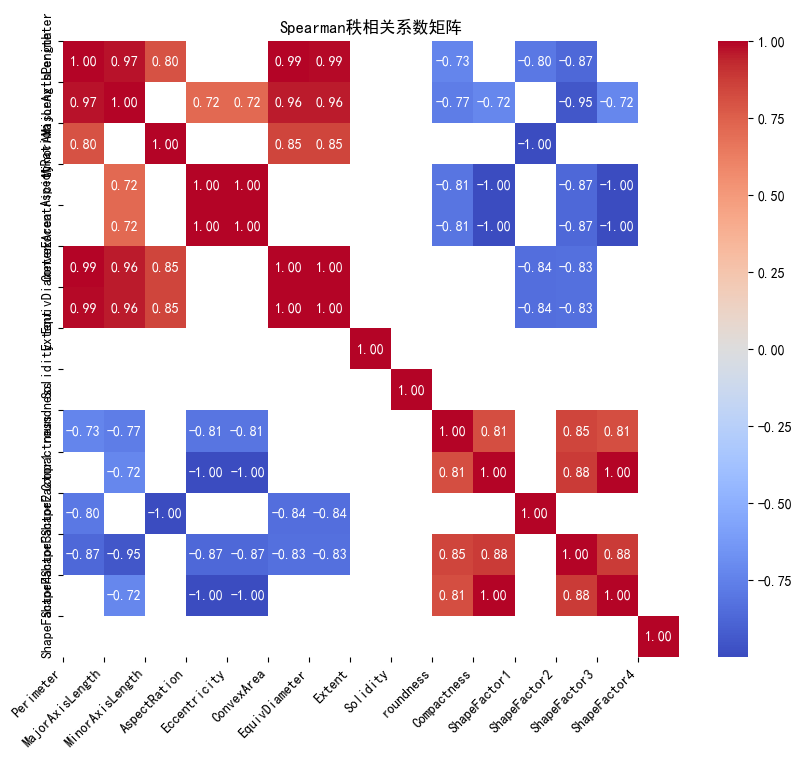

In [3]:
model = load_model('test_model\\test_mul_cnn_lstm.h5')#加载CNN模型
df = pd.read_csv("Dataset\\test.csv",encoding="gbk")
column_names = df.columns[1:-1].tolist()
feature_dict = {}
spearmanr_data = df.iloc[:,1:-1]
feature_dict = set_feature_dict(column_names,feature_dict)
rela_class,feature_dict,feature_correlation_list = Feature_correlation_analysis(column_names,feature_dict,spearmanr_data)
target_variable = df['Class']
column_names = df.columns[1:-1]
feature_dict,target_variable_list = target_correlation_analysis(feature_dict,target_variable,column_names)

Running time: 118.9490778 Seconds
Running time: 121.5065131 Seconds


C:\Users\liang\AppData\Local\Temp\ipykernel_19744\3054686753.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,80))


Running time: 123.33131689999999 Seconds


C:\Users\liang\AppData\Local\Temp\ipykernel_19744\3054686753.py:21: UserWarning: Attempting to set identical bottom == top == [0.] results in singular transformations; automatically expanding.
  plt.ylim(y_list_min[i]*1.1,y_list_max[i]*1.5)


Running time: 125.67344109999993 Seconds
Running time: 116.63915159999999 Seconds
Running time: 117.71178800000007 Seconds
Running time: 114.9110746 Seconds


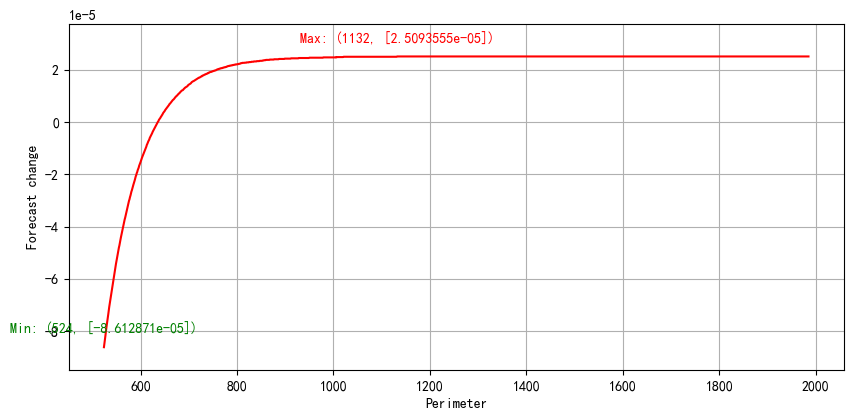

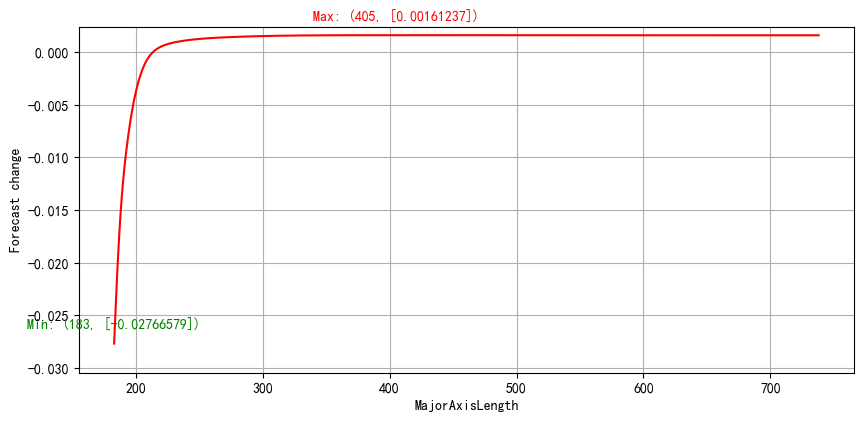

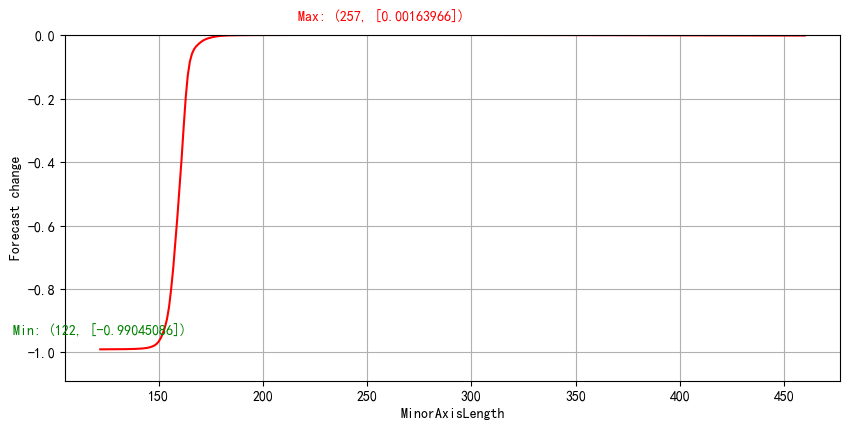

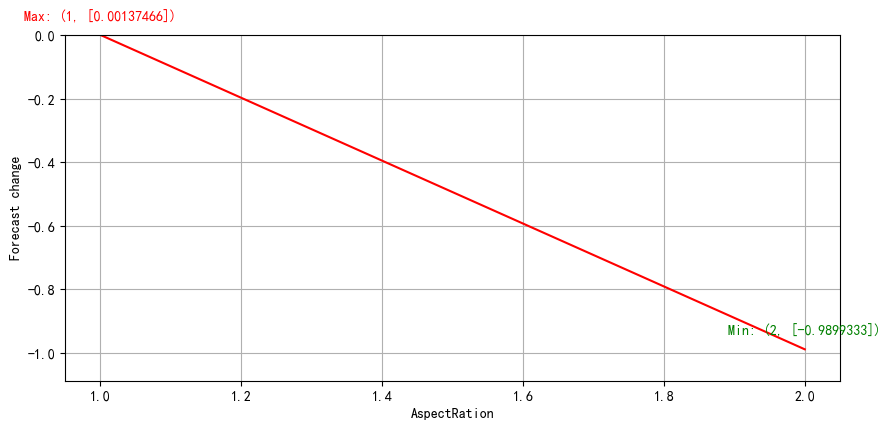

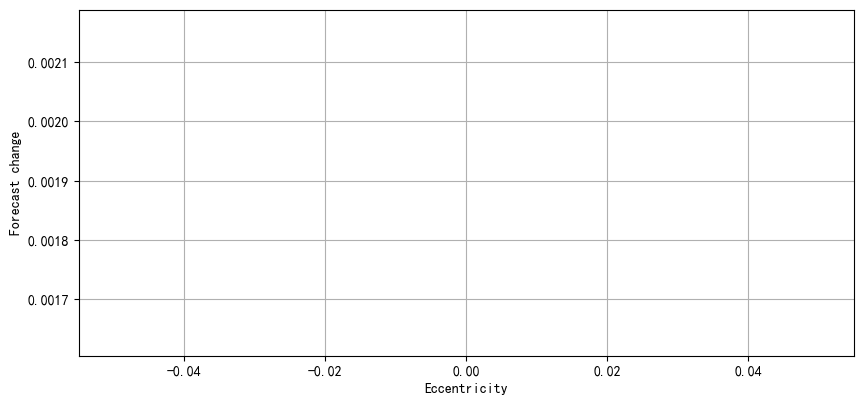

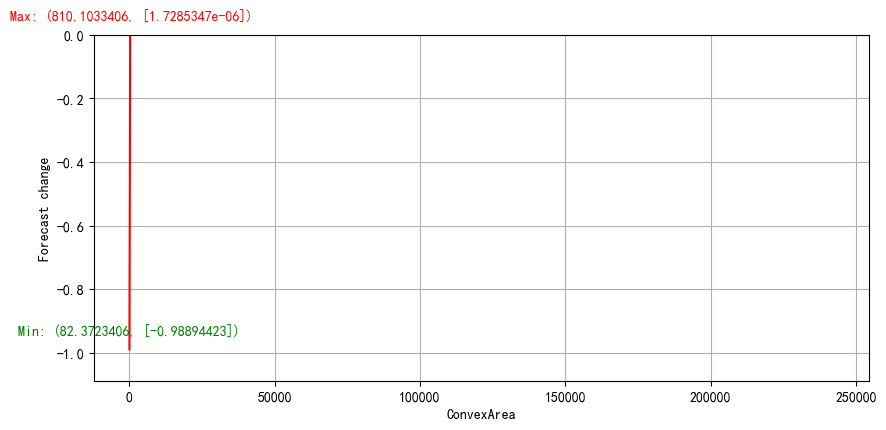

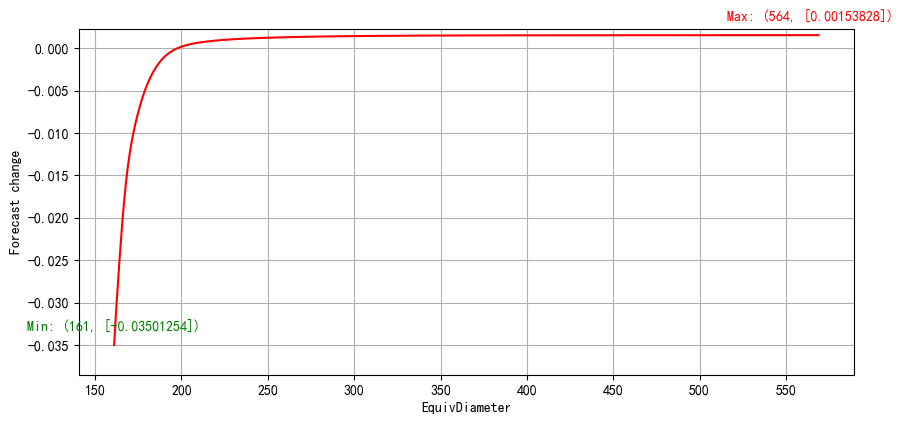

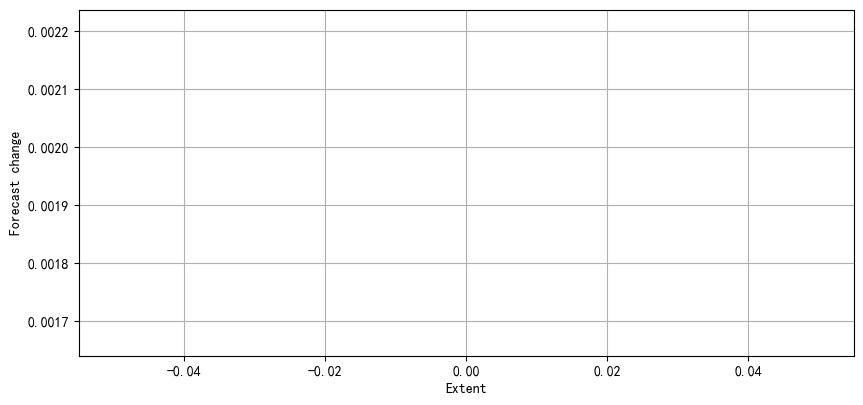

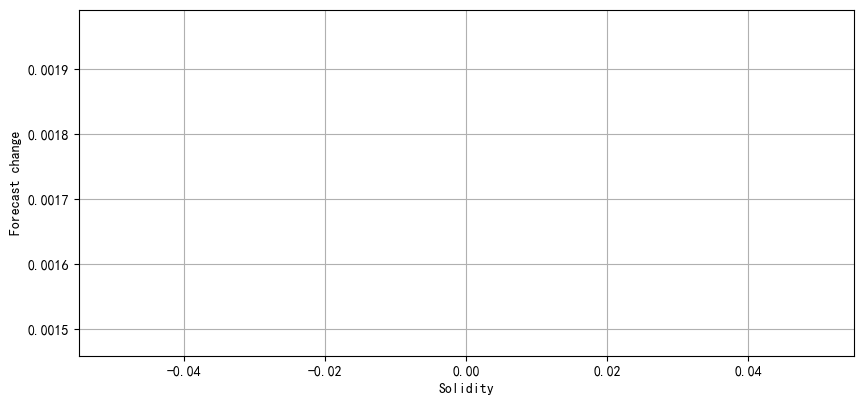

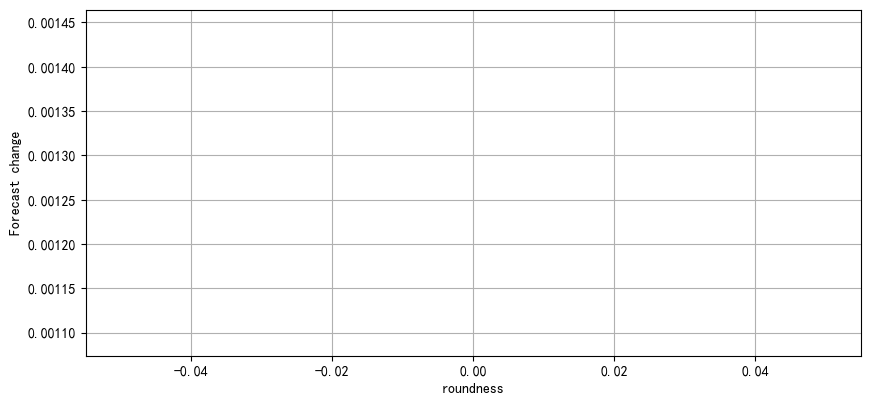

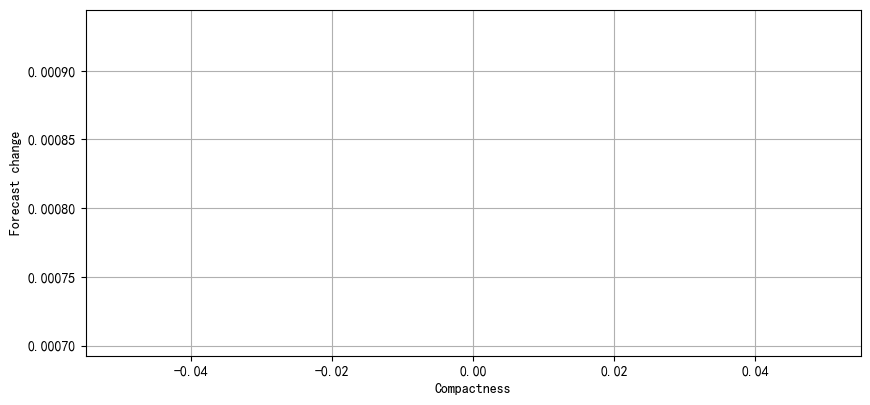

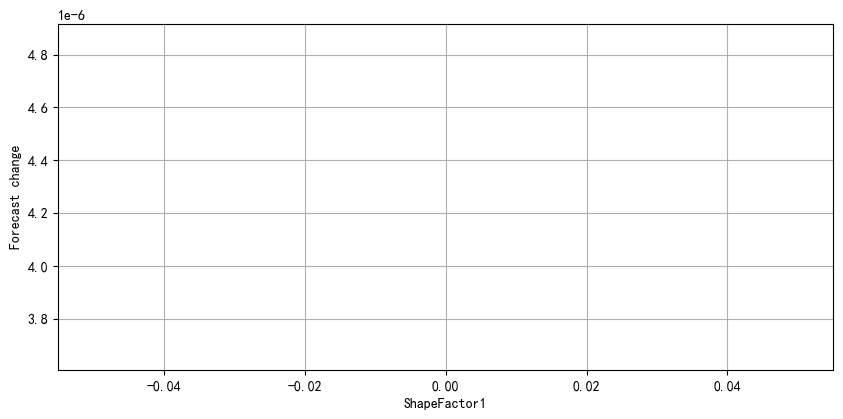

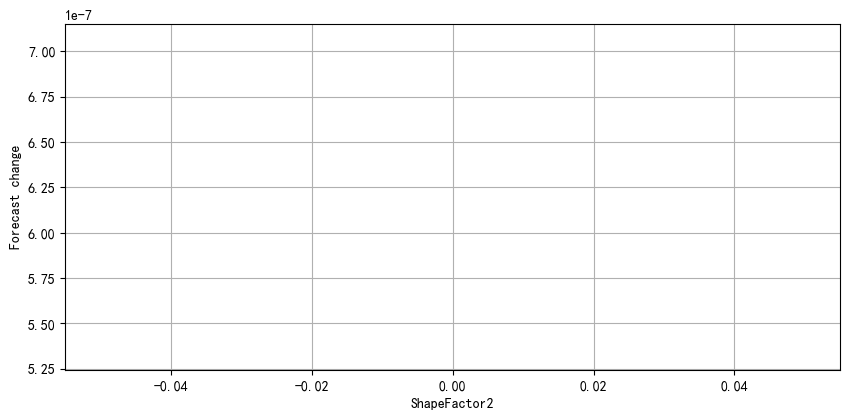

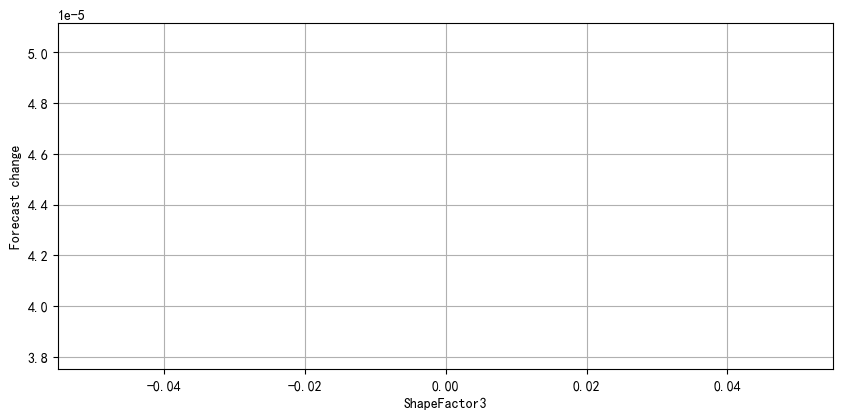

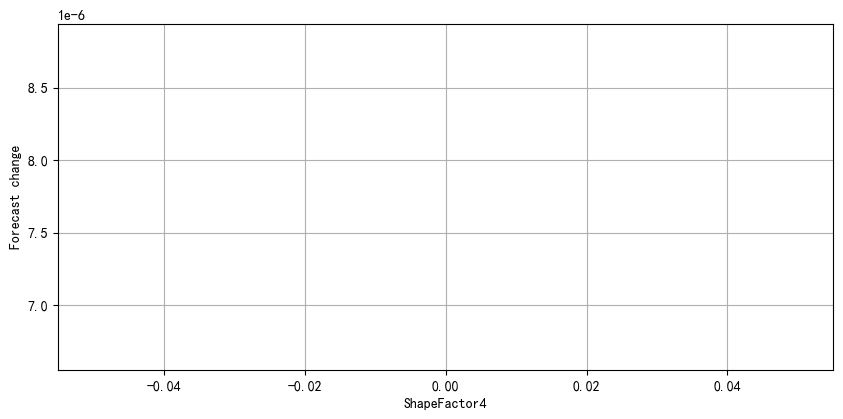

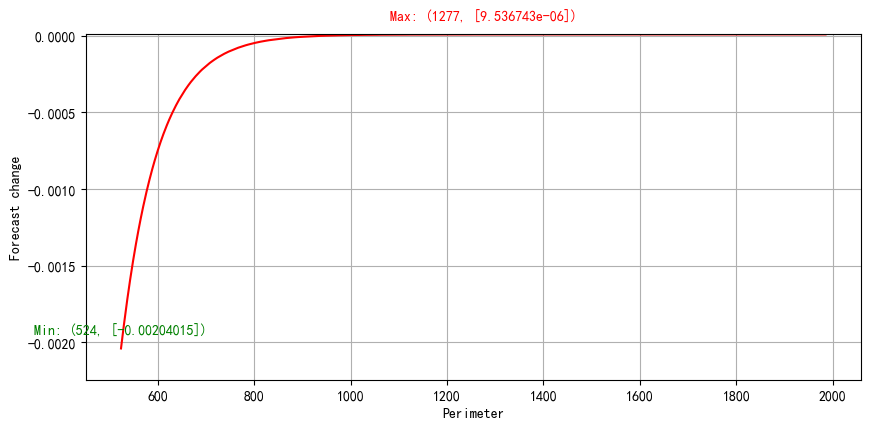

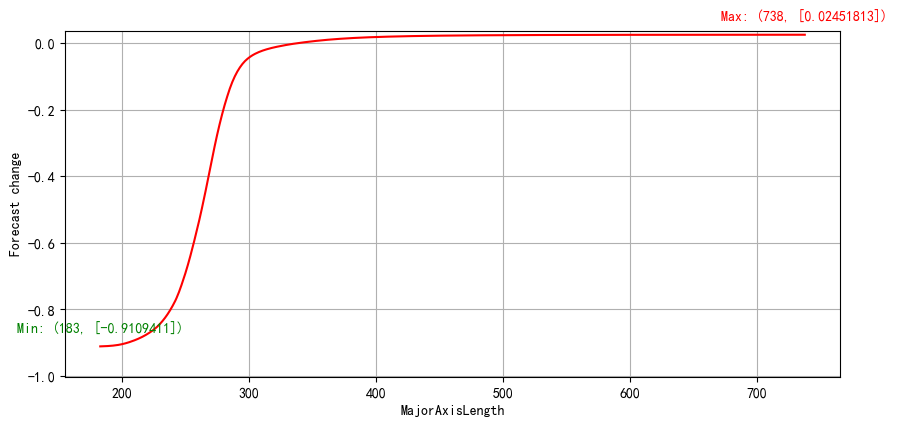

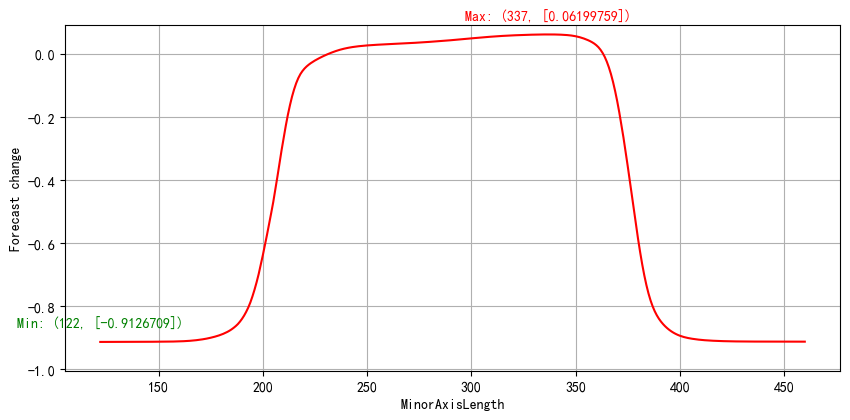

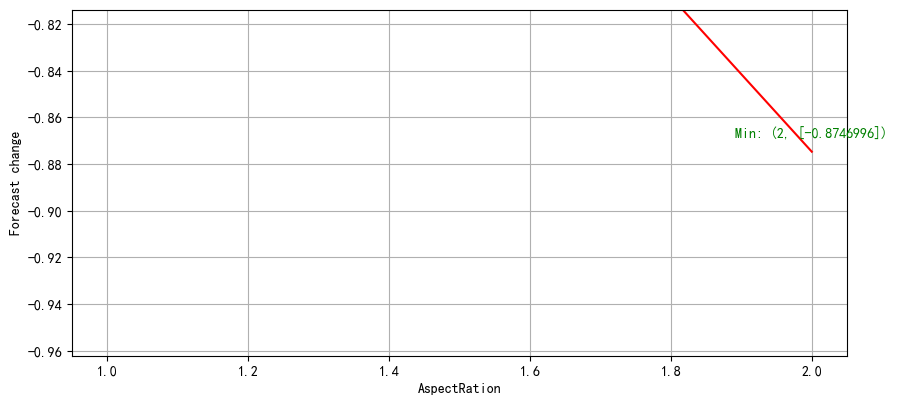

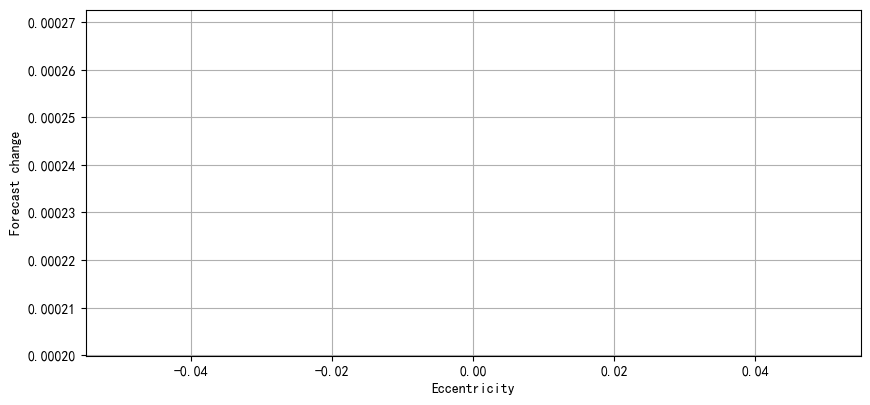

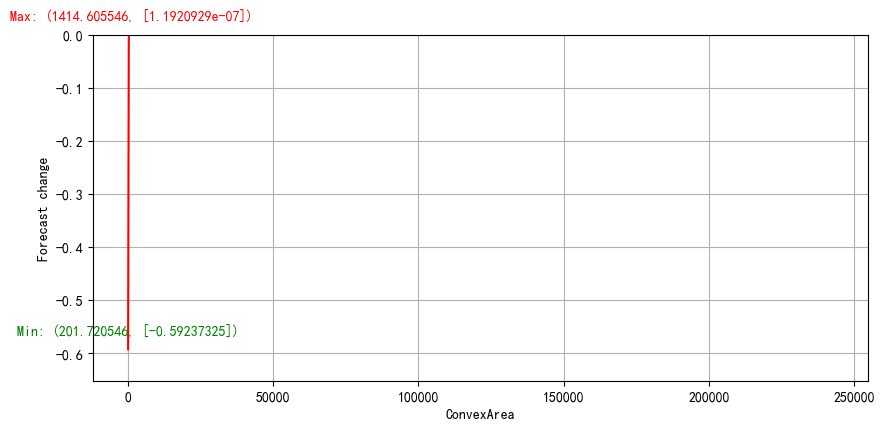

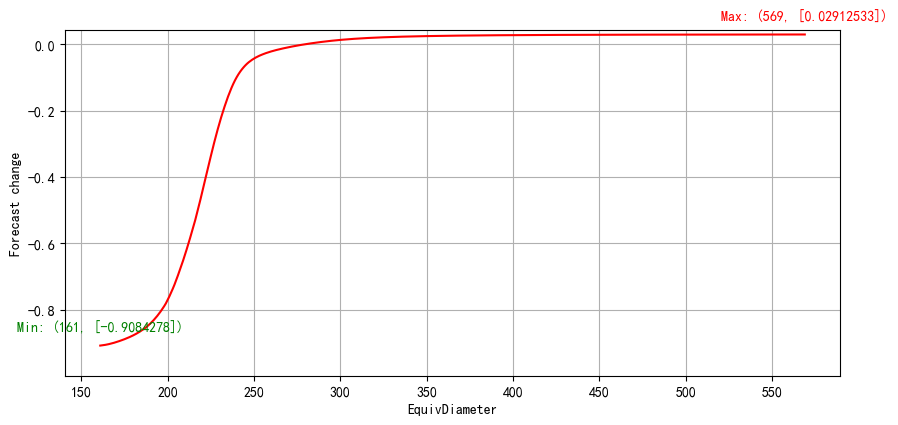

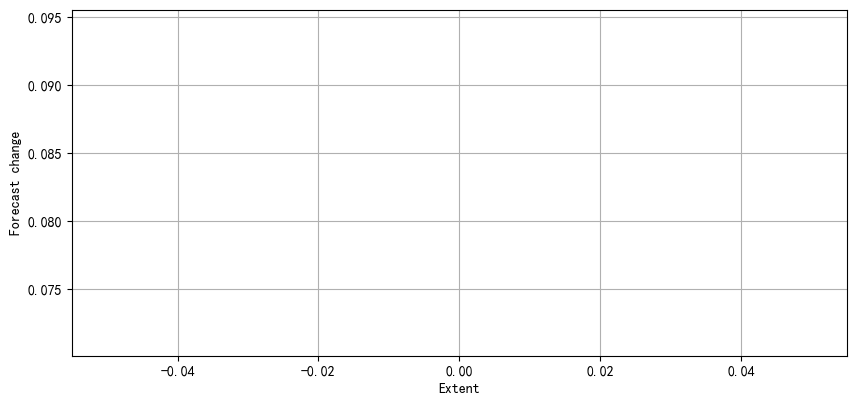

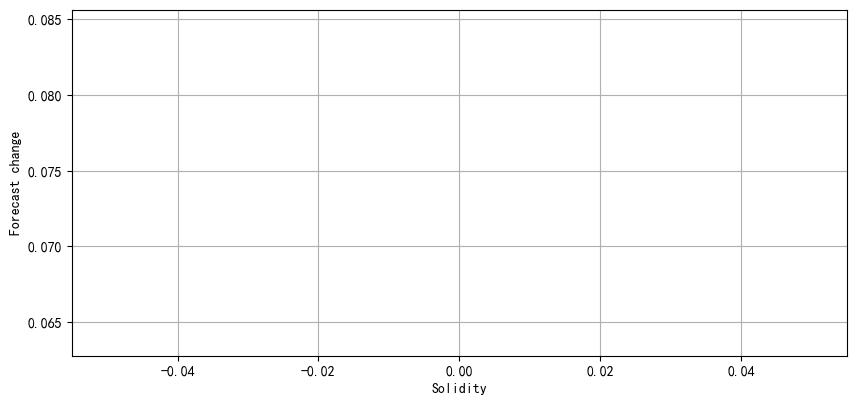

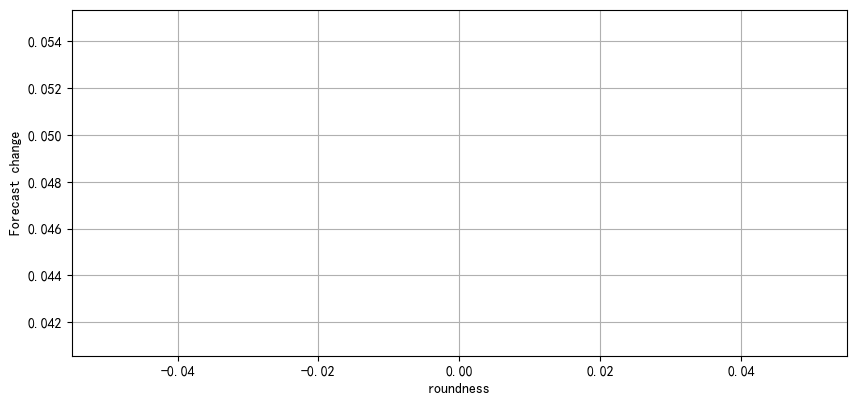

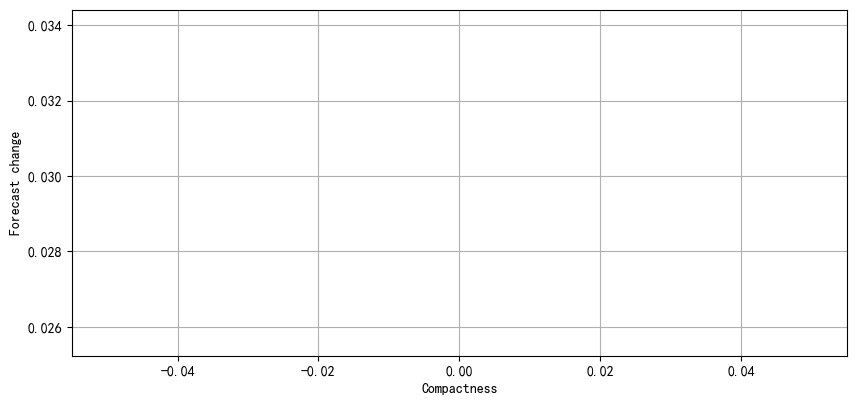

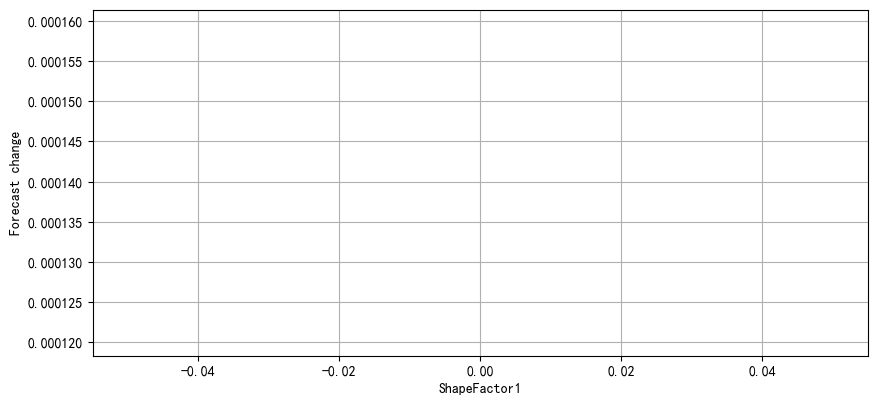

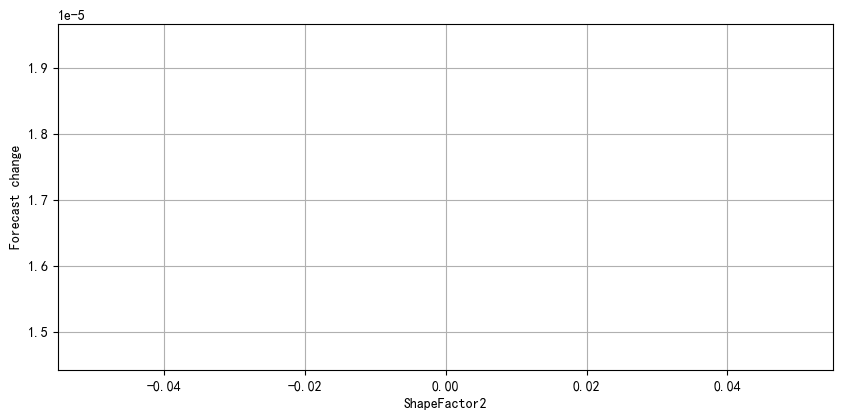

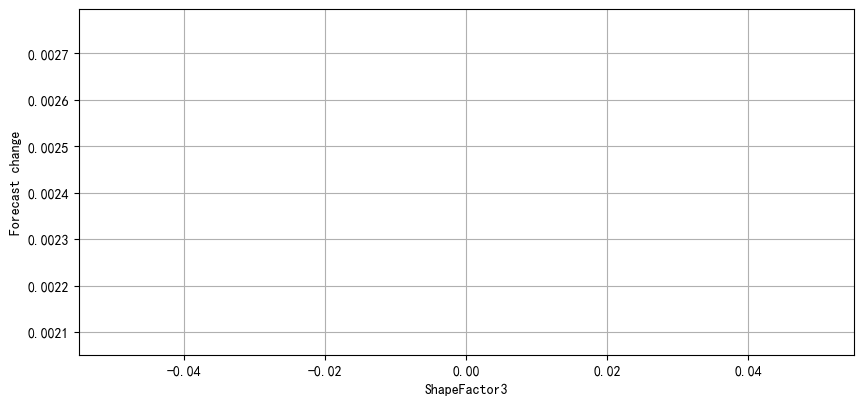

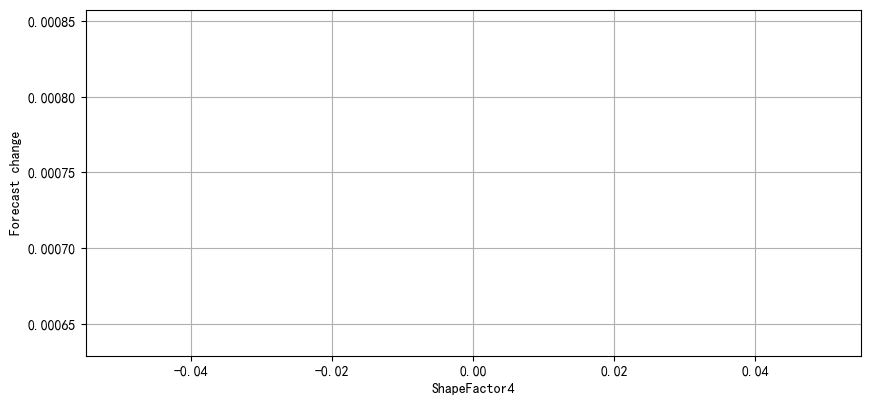

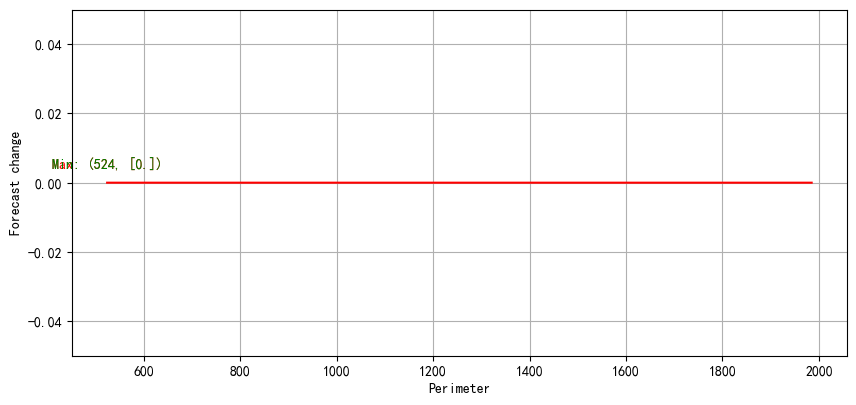

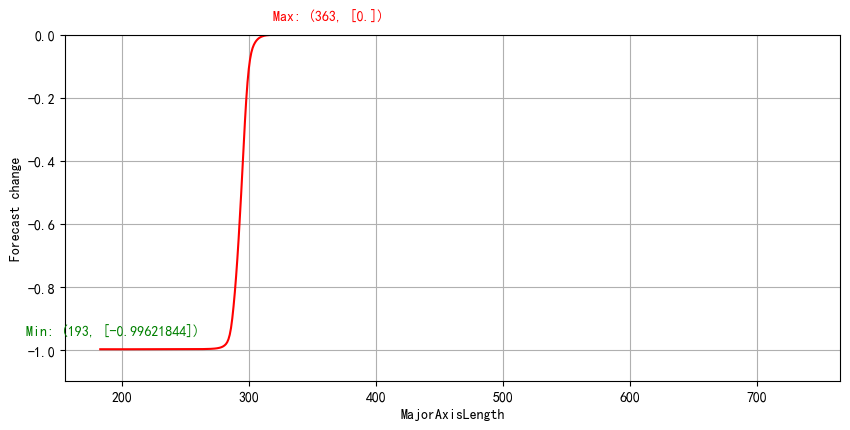

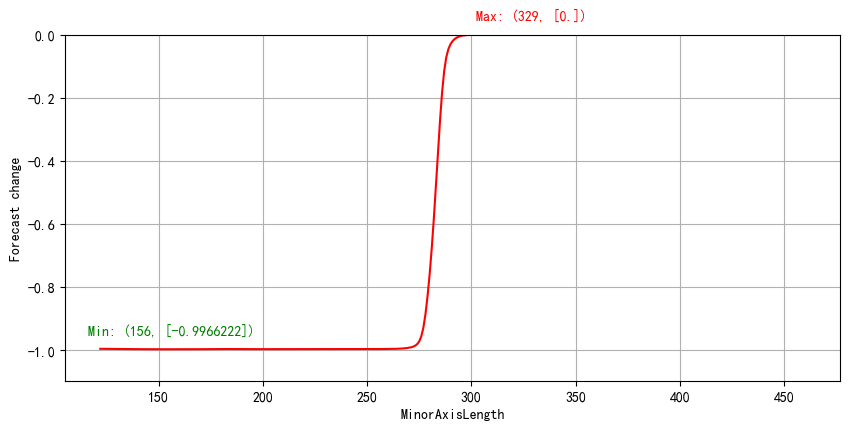

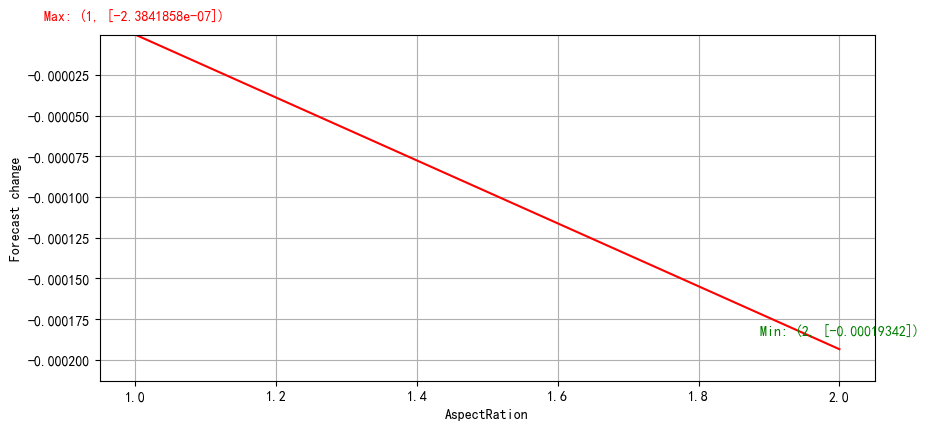

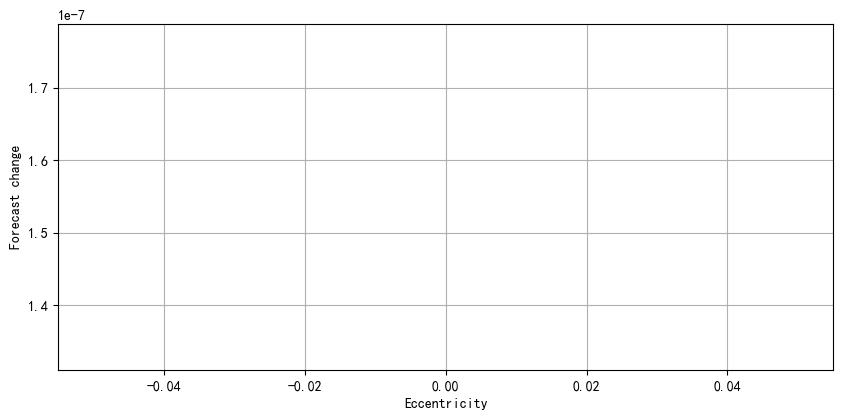

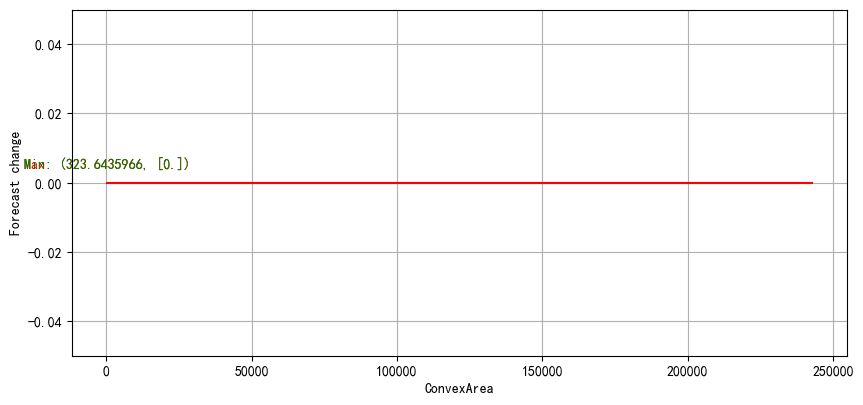

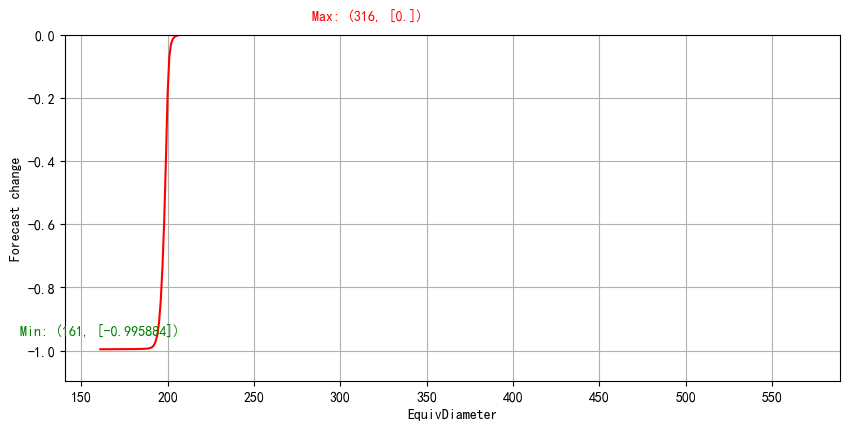

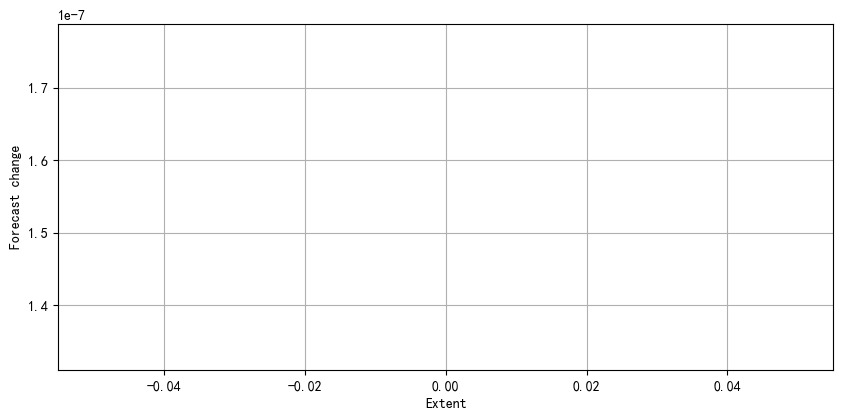

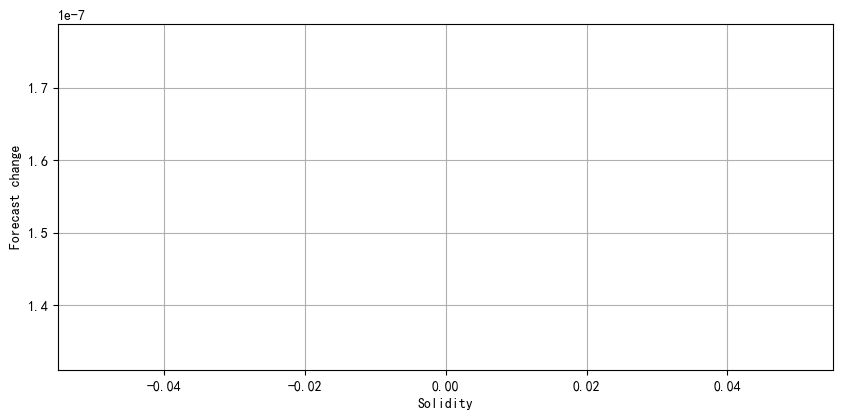

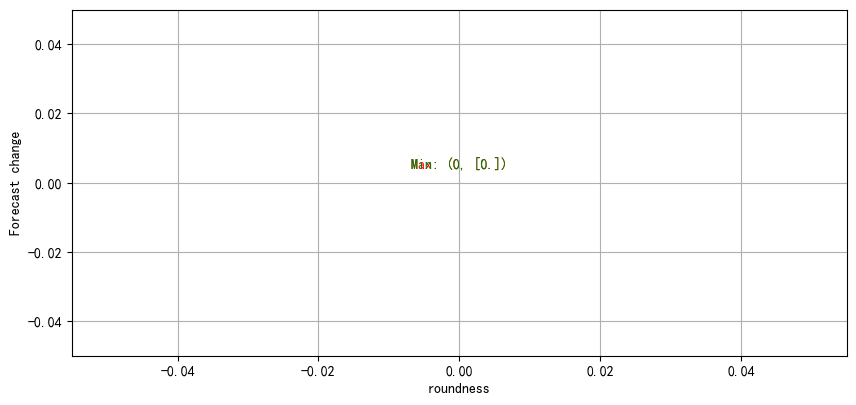

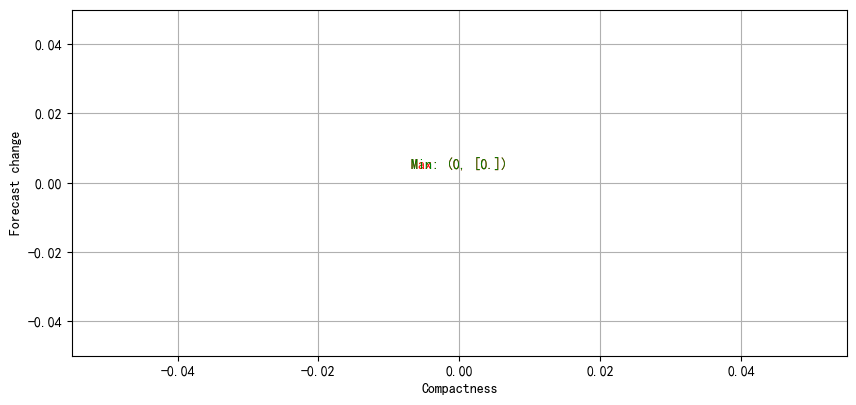

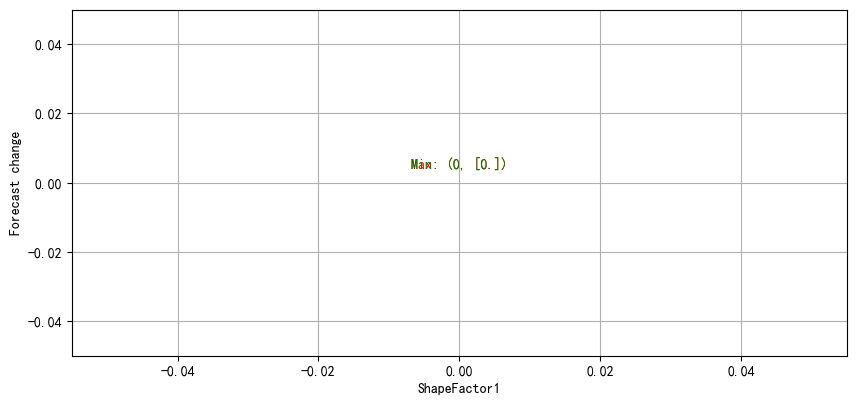

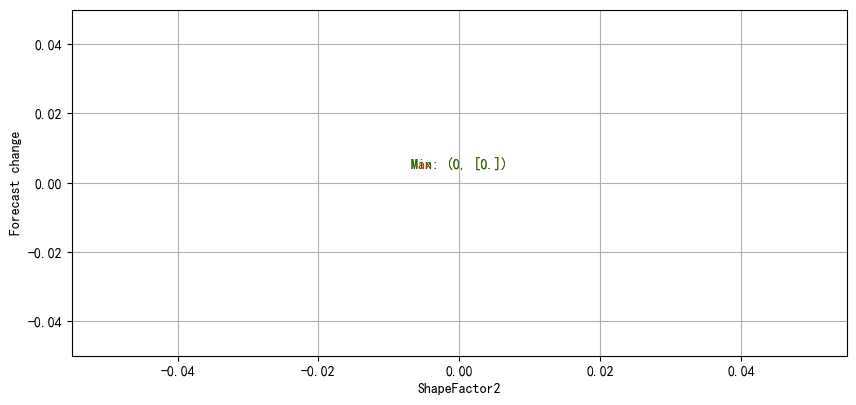

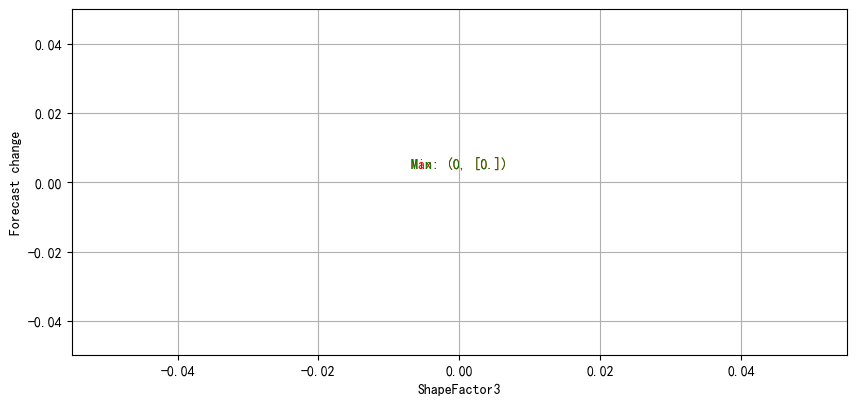

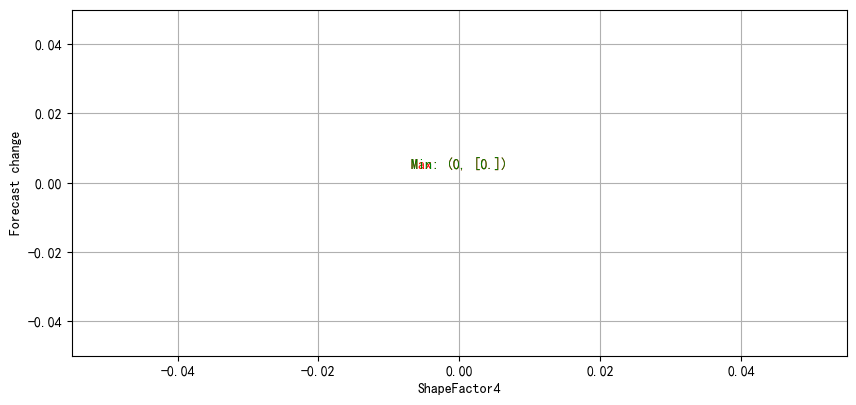

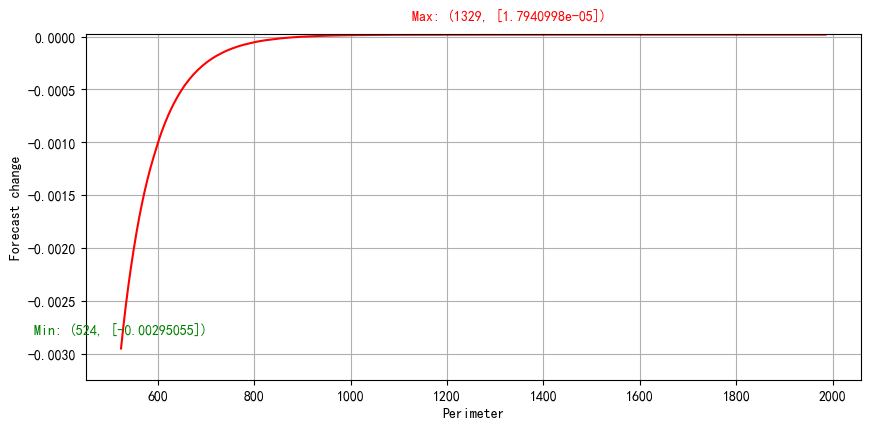

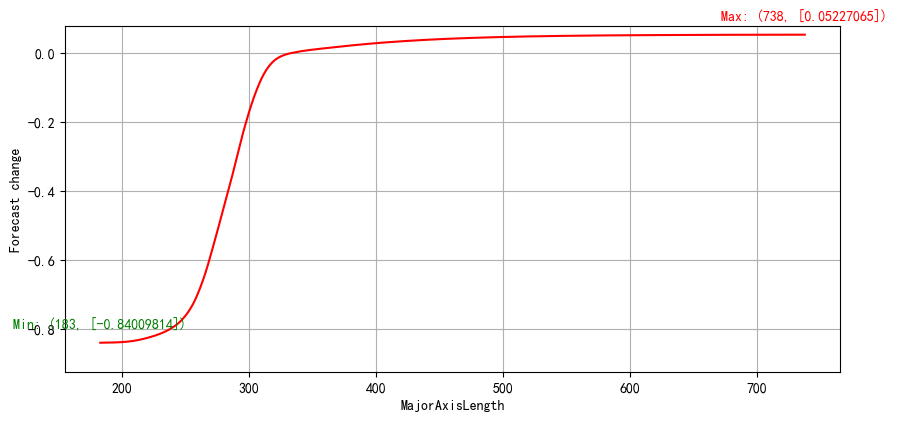

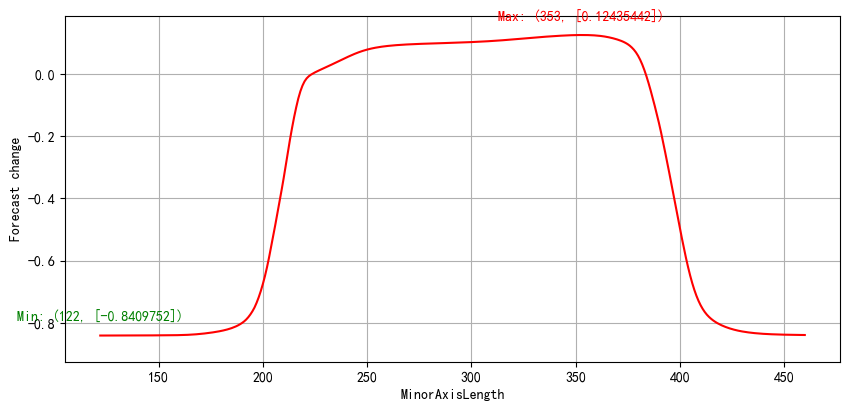

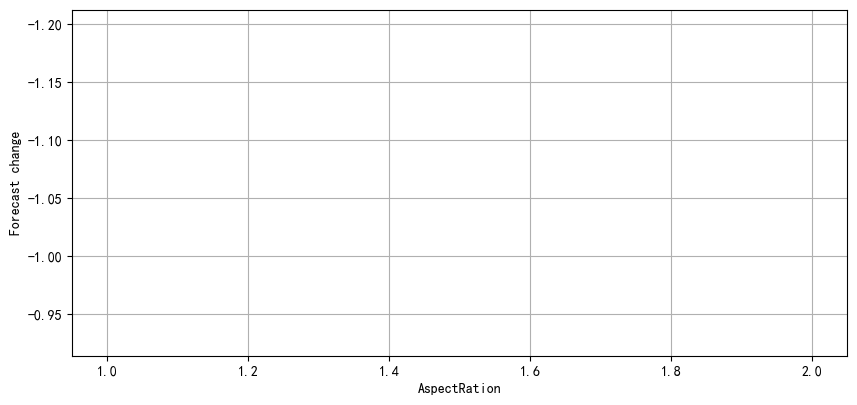

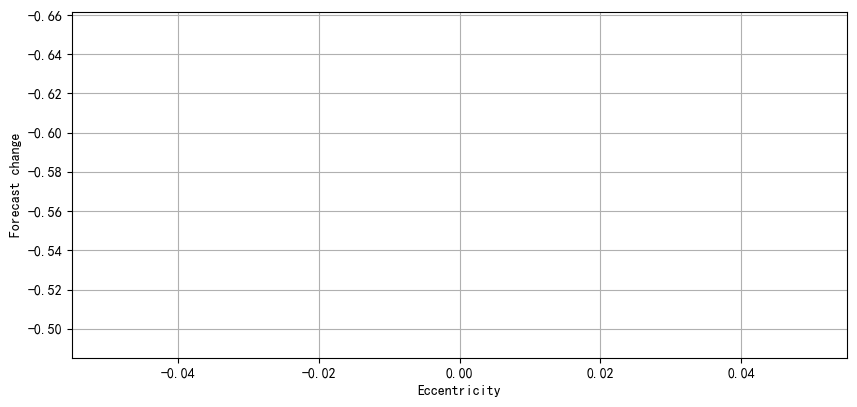

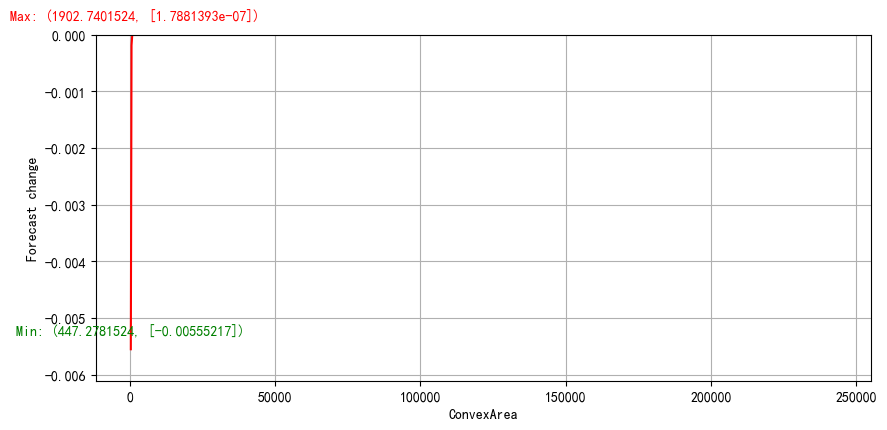

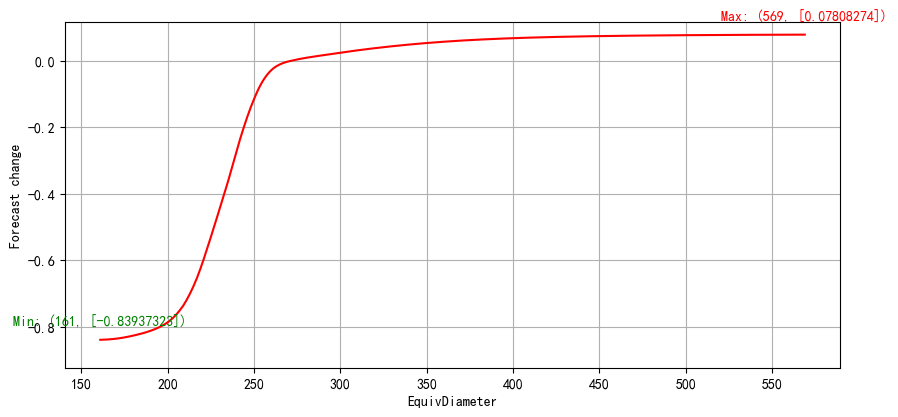

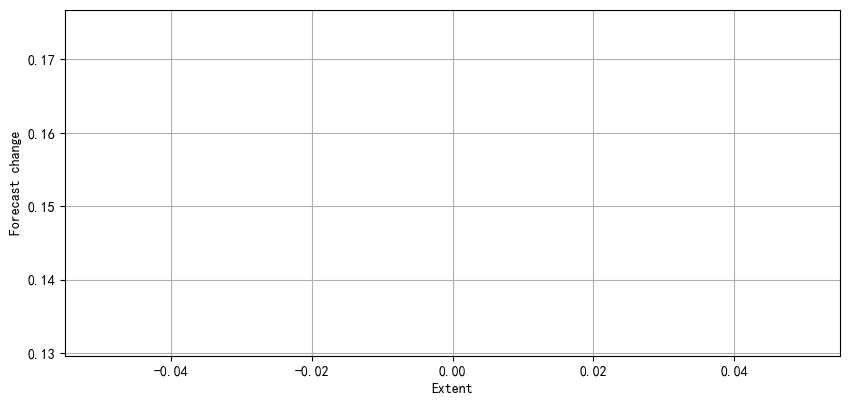

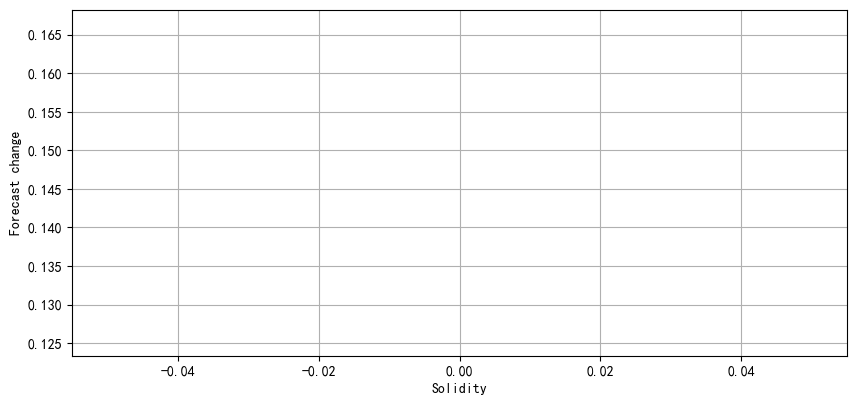

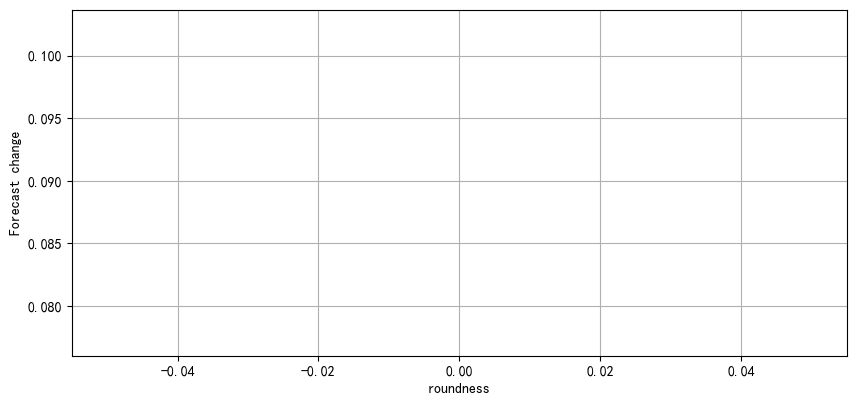

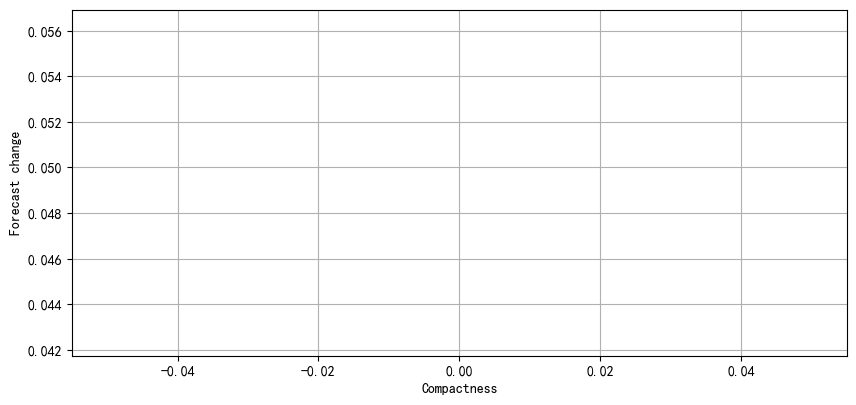

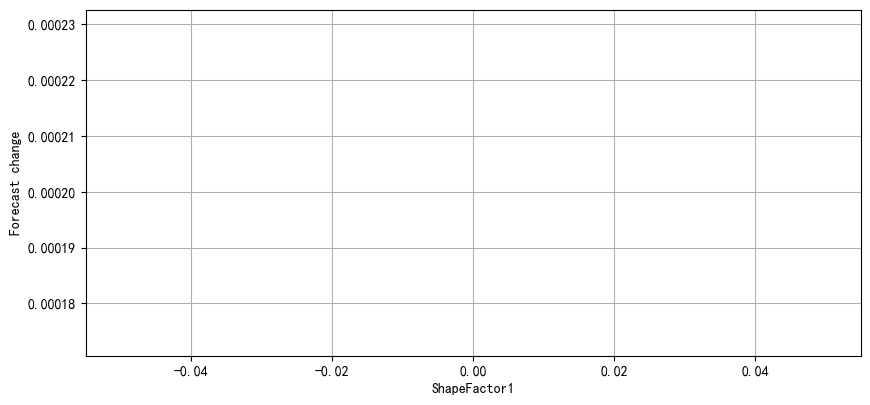

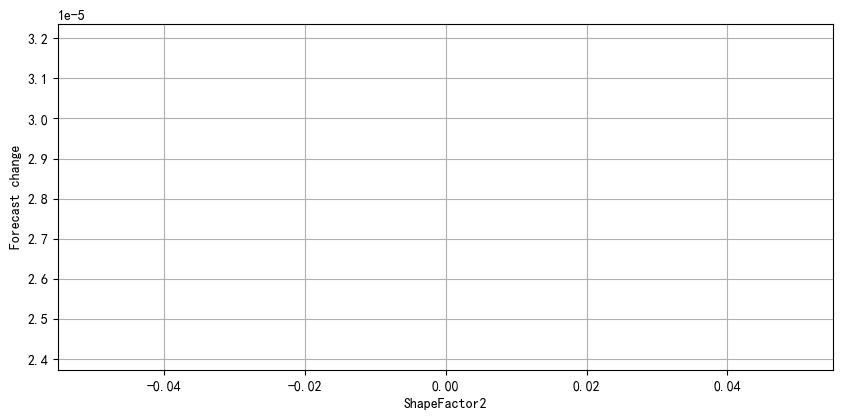

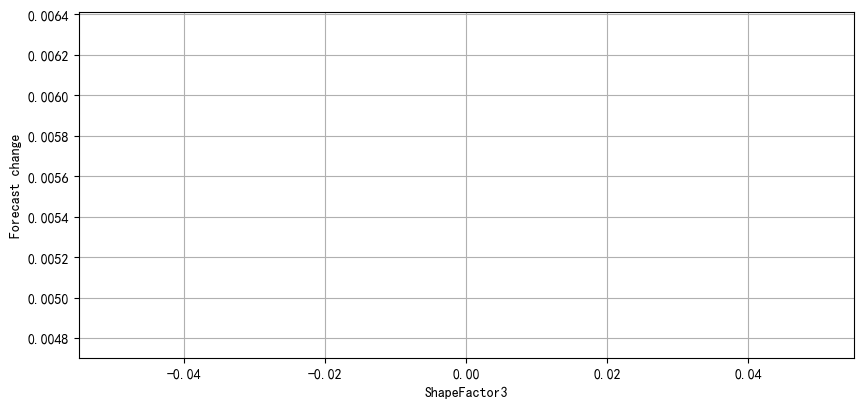

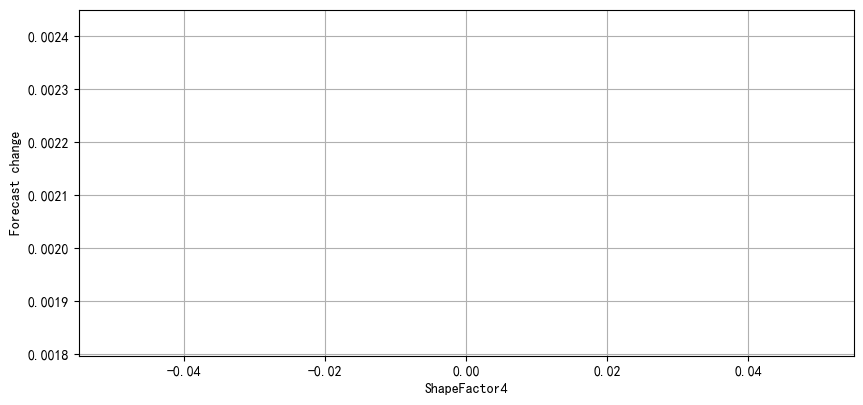

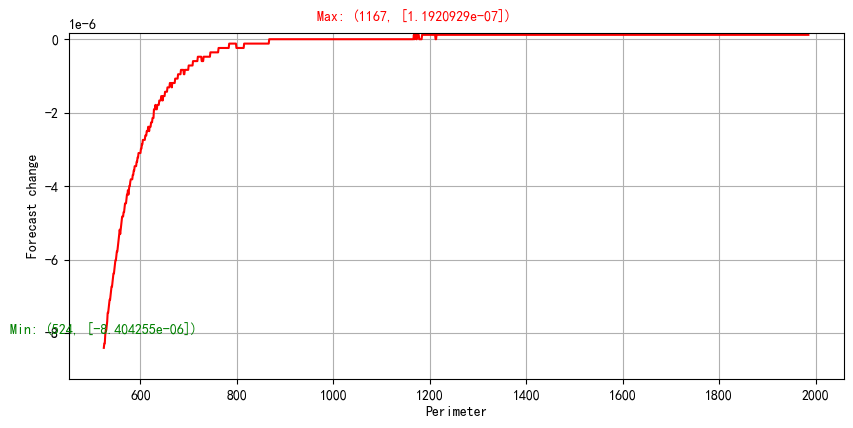

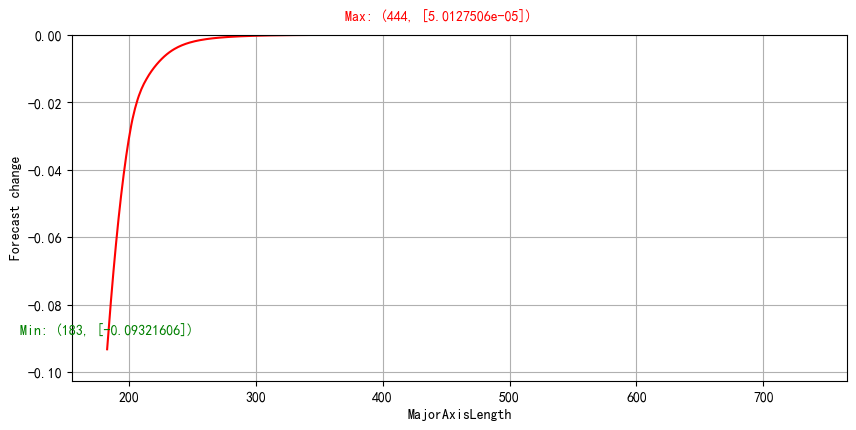

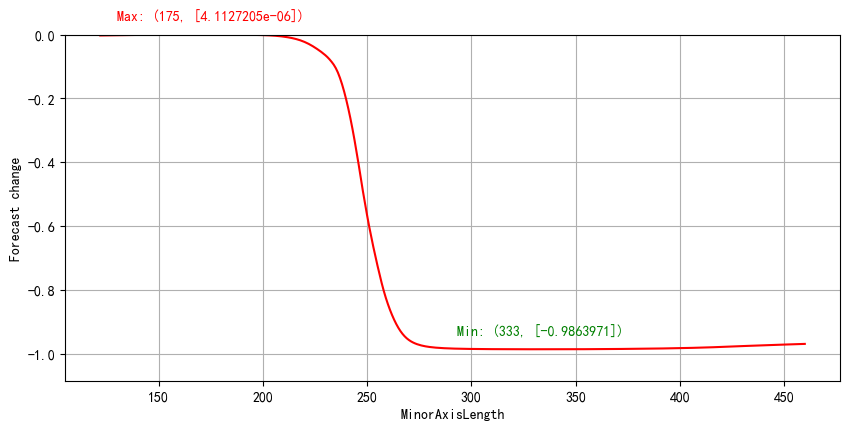

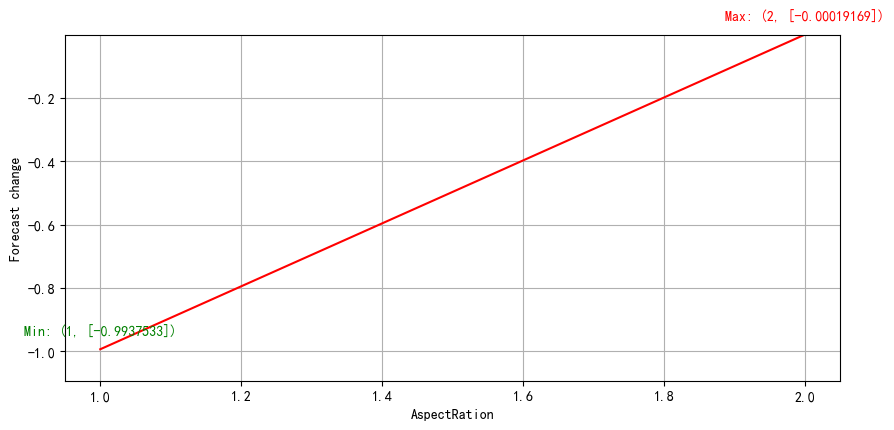

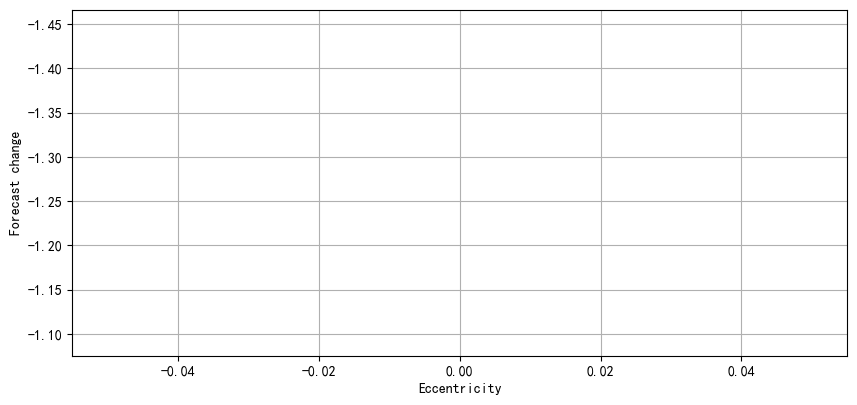

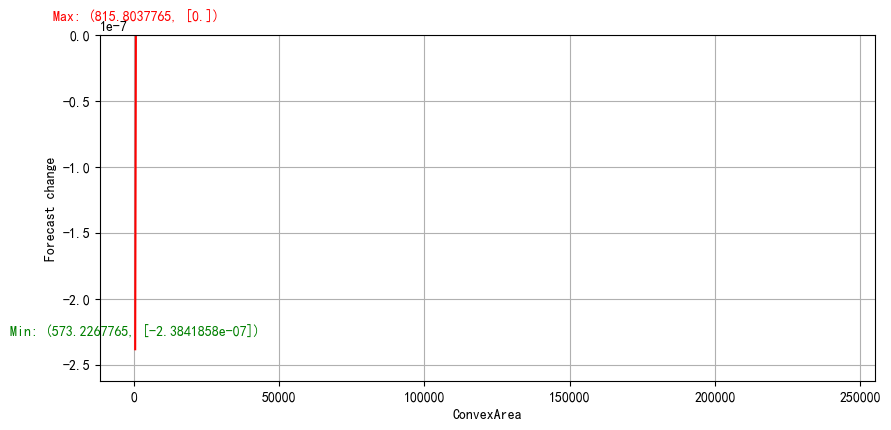

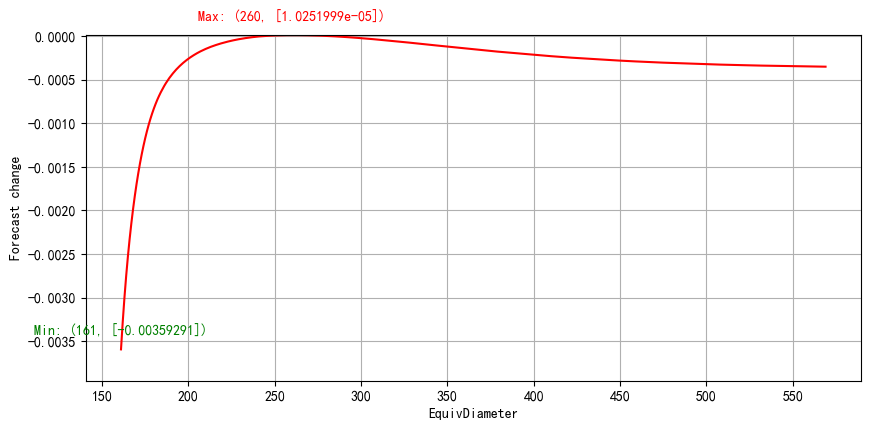

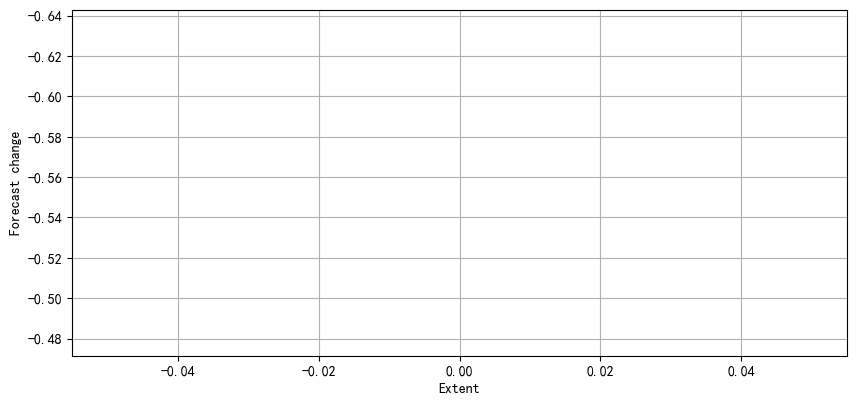

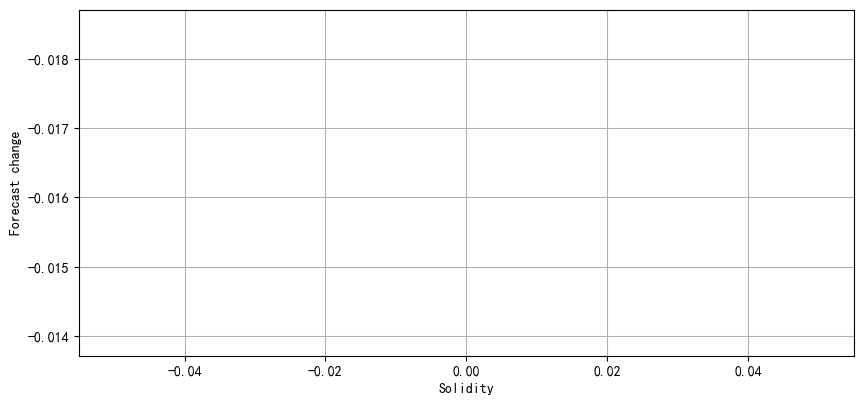

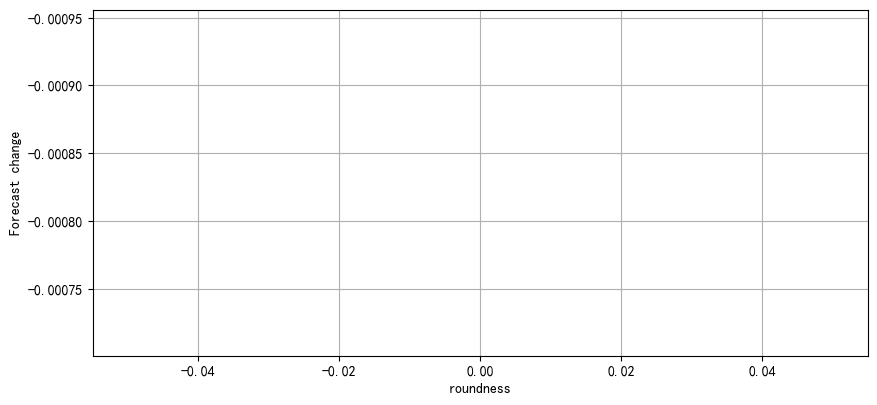

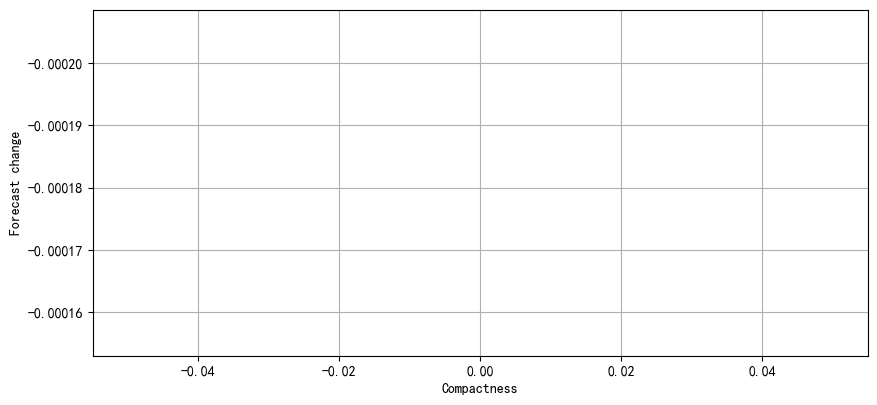

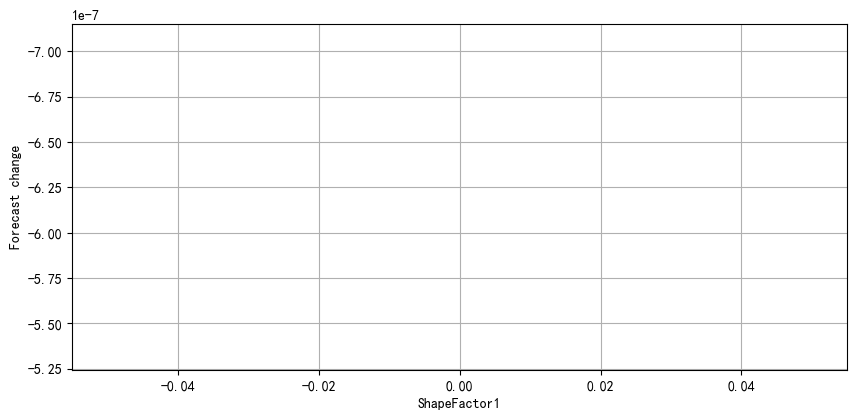

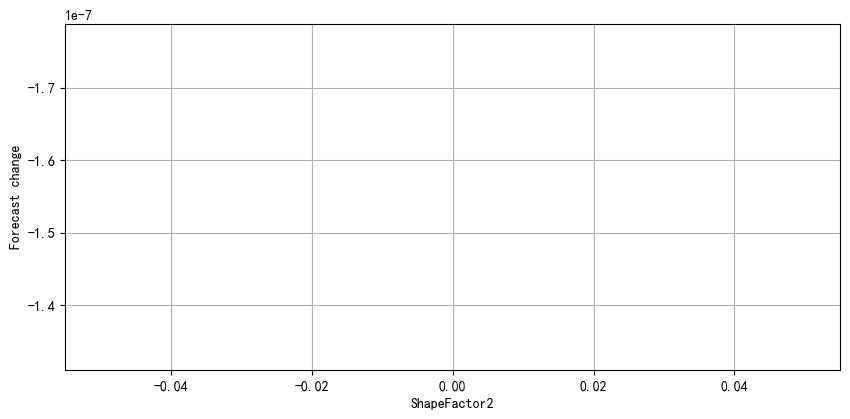

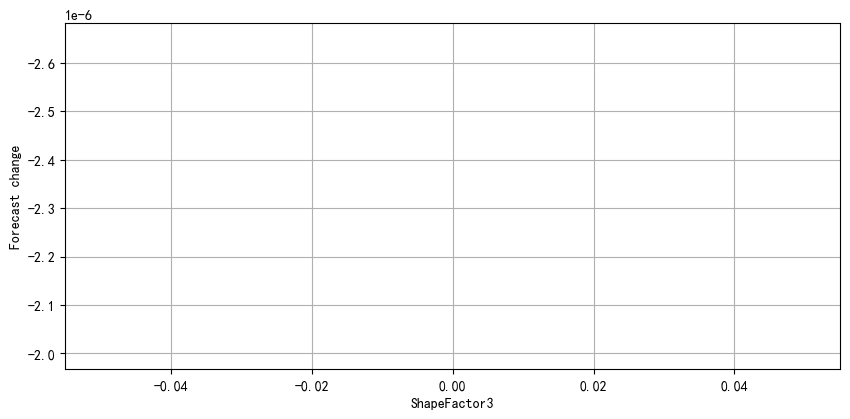

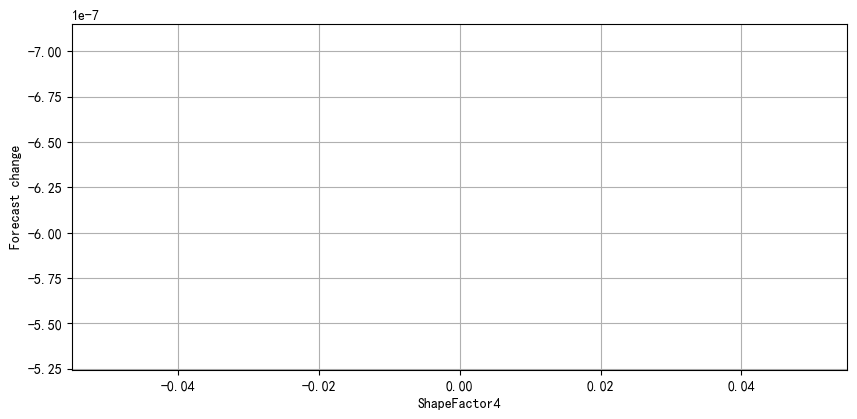

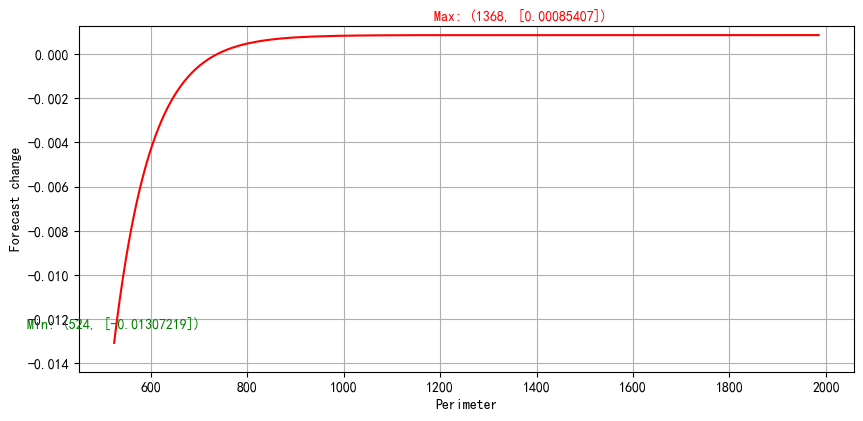

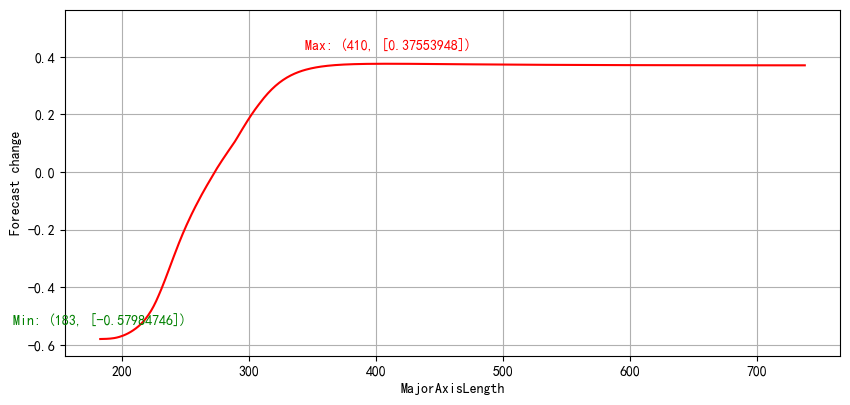

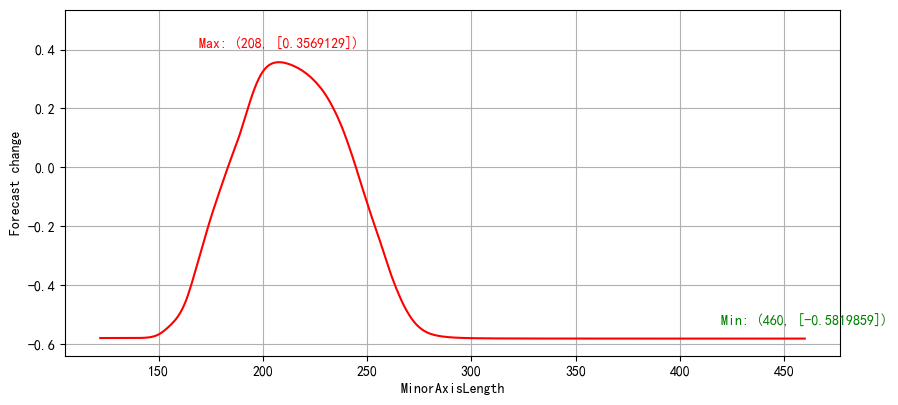

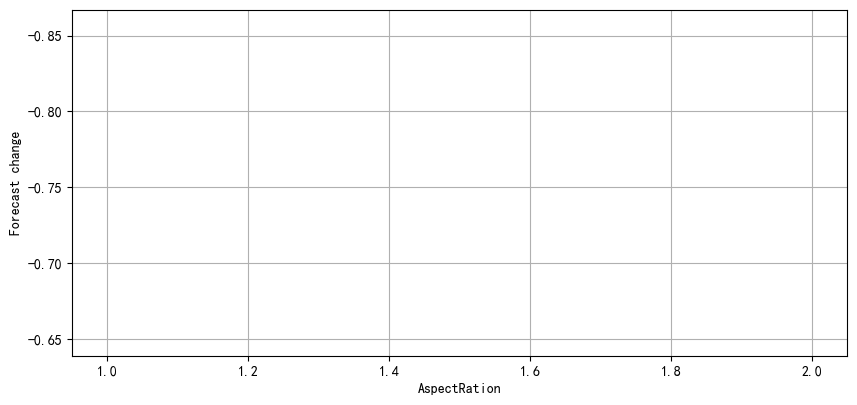

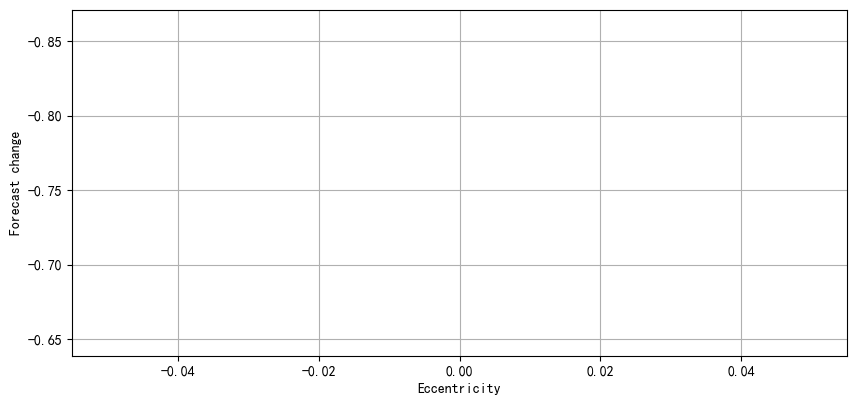

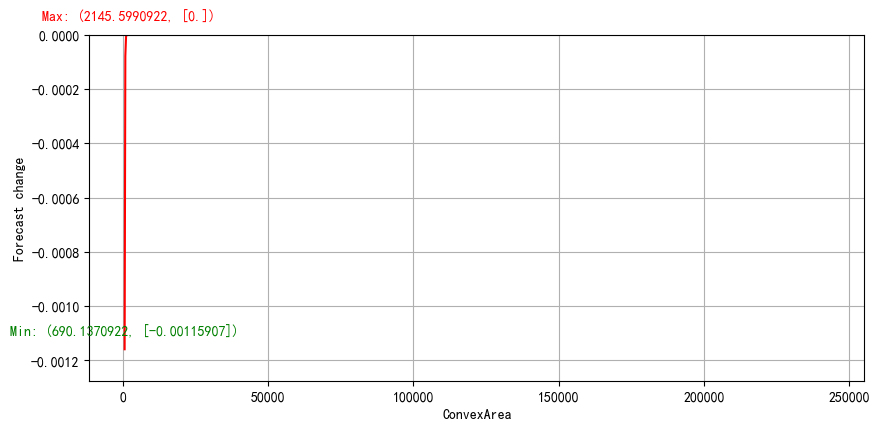

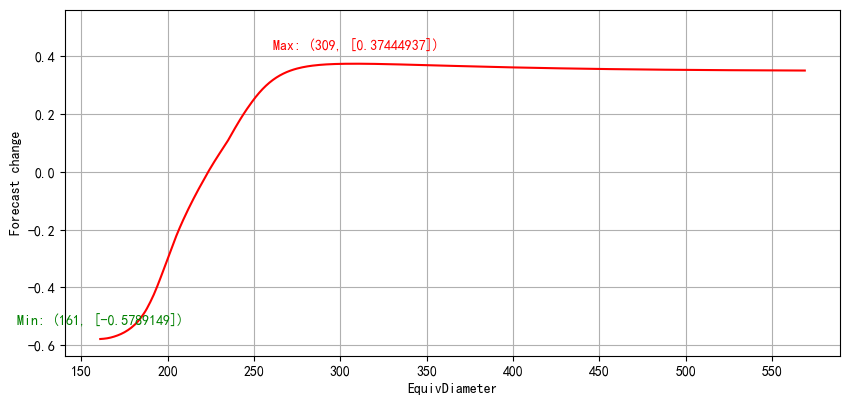

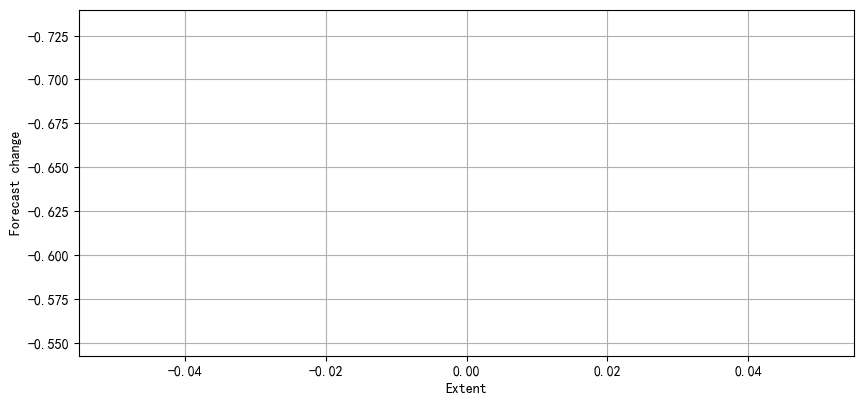

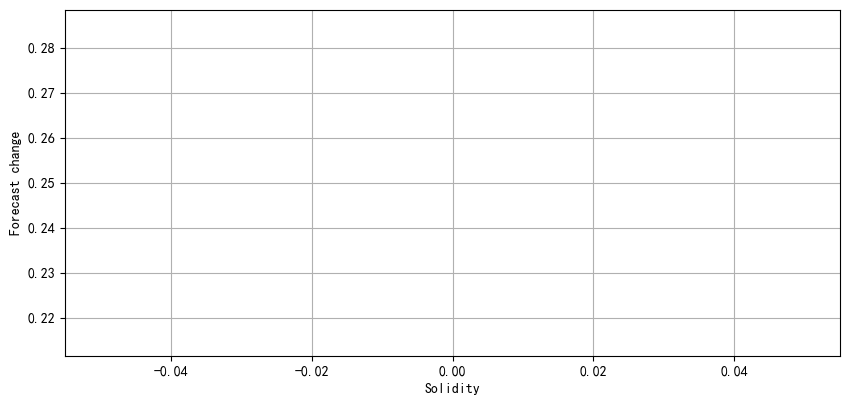

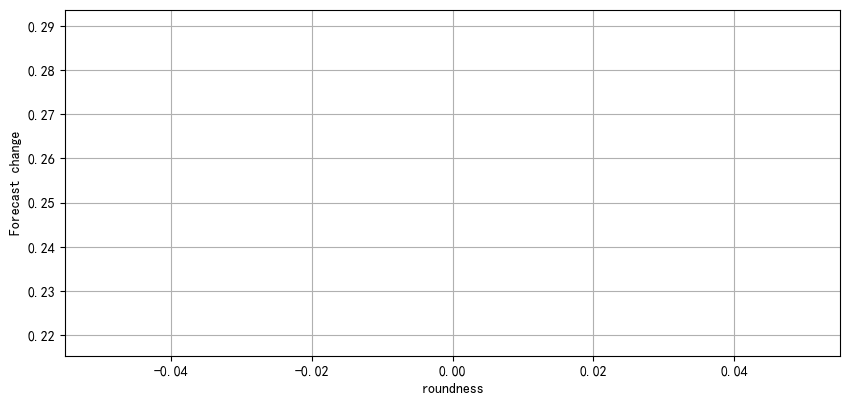

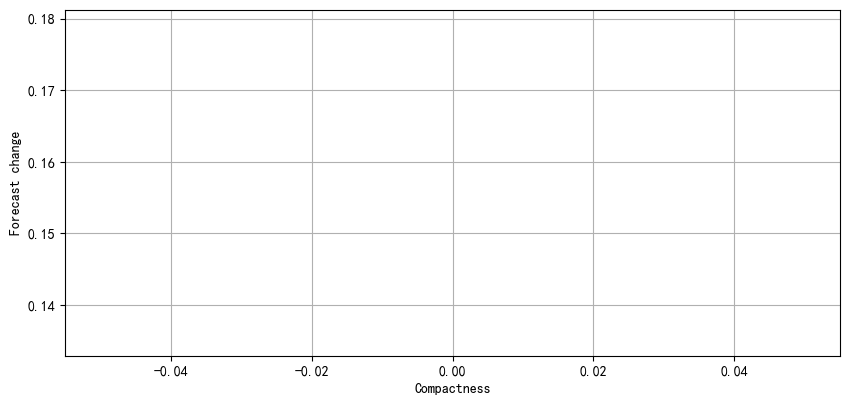

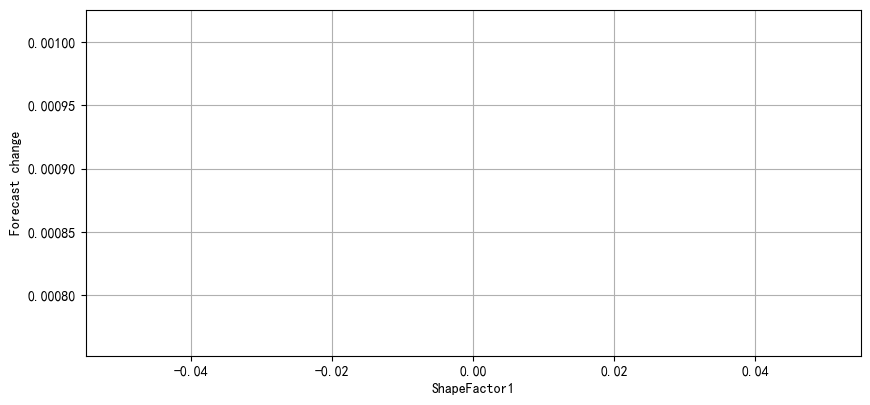

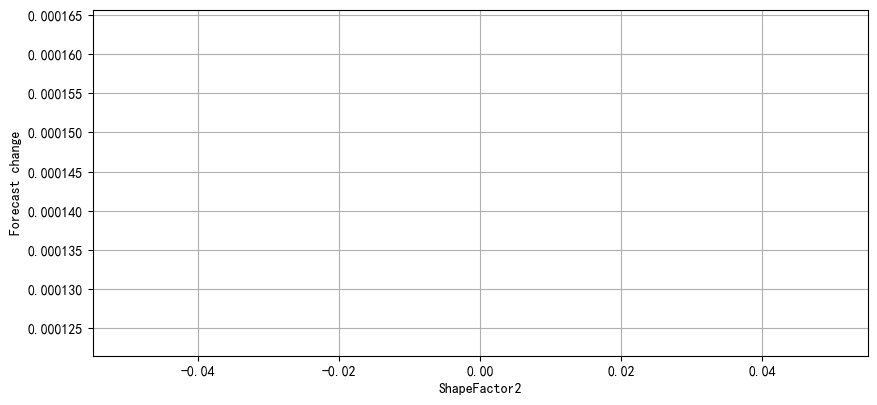

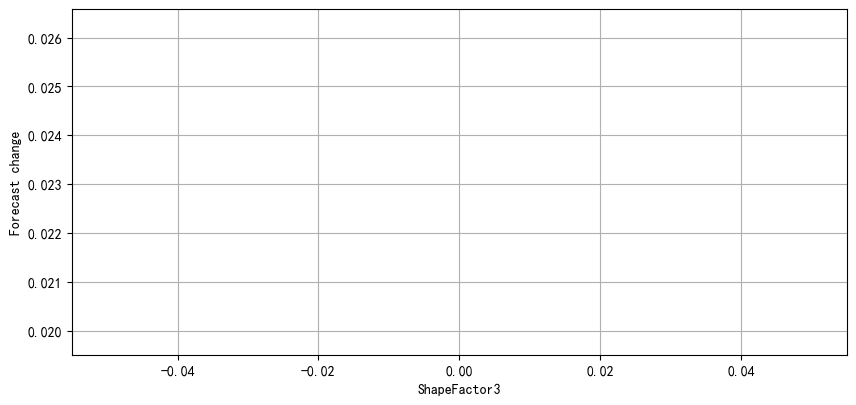

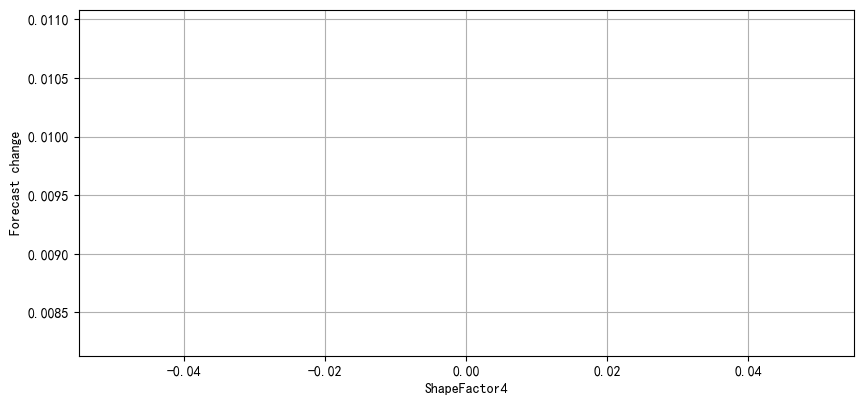

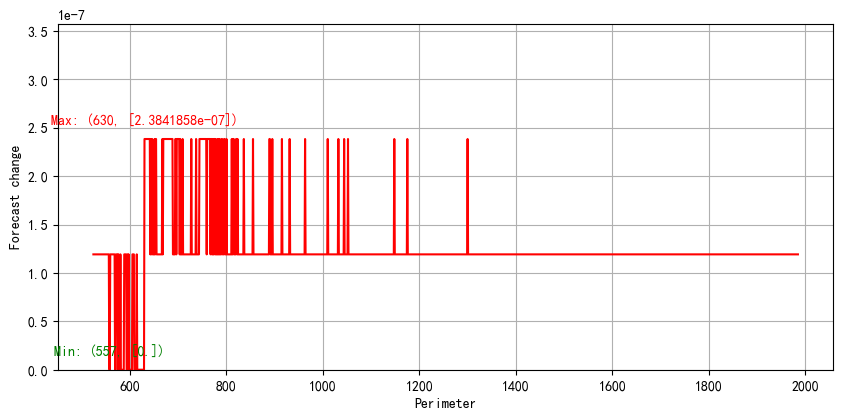

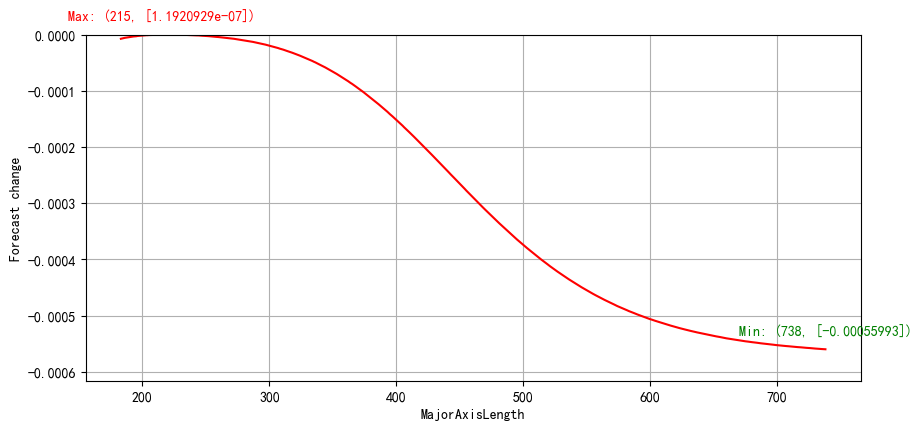

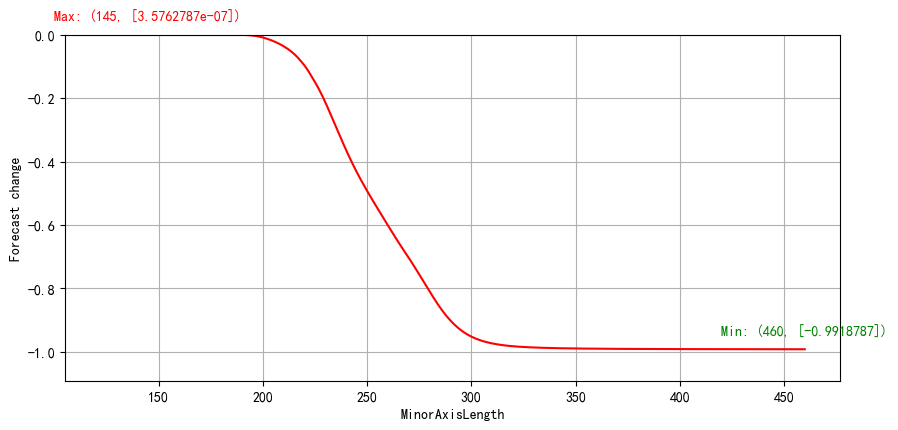

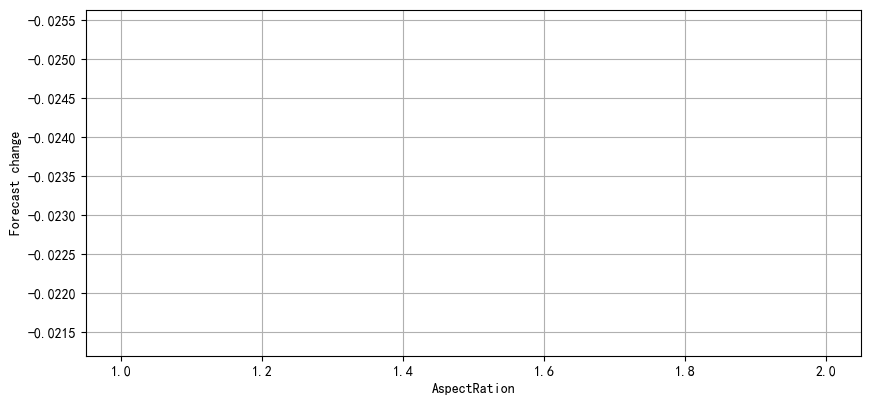

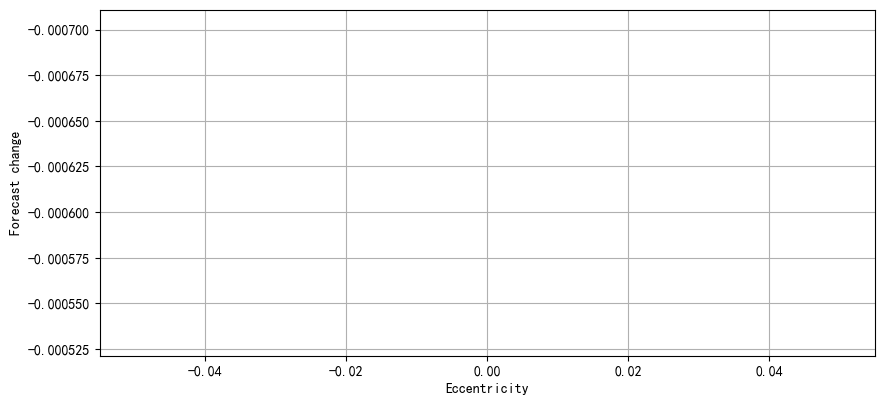

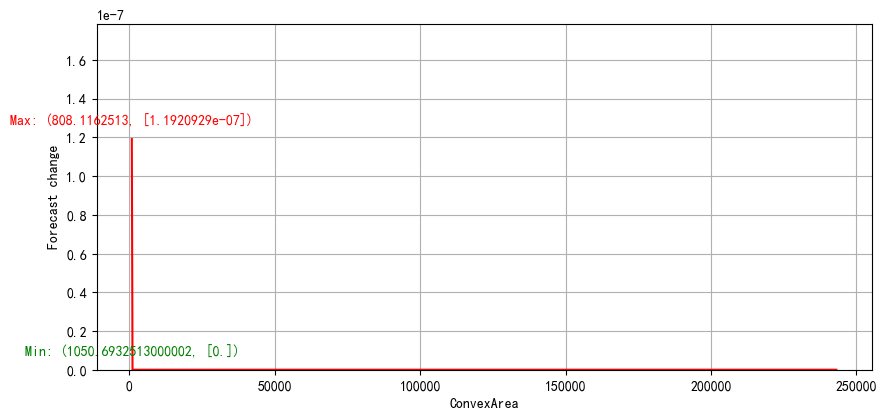

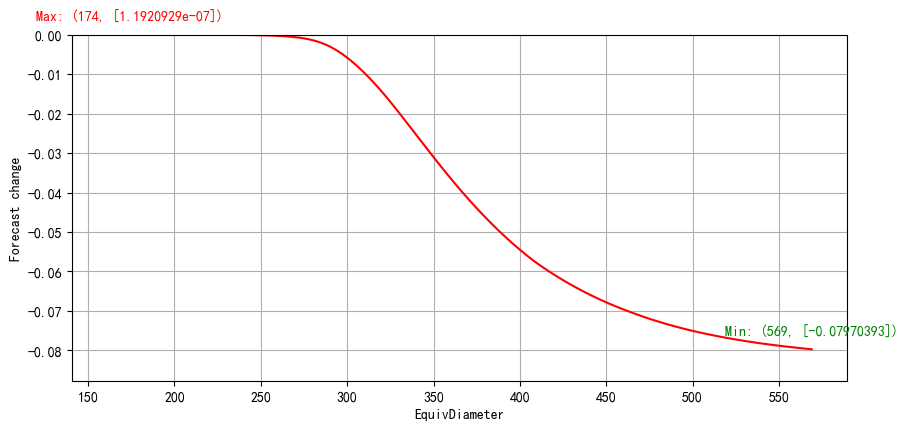

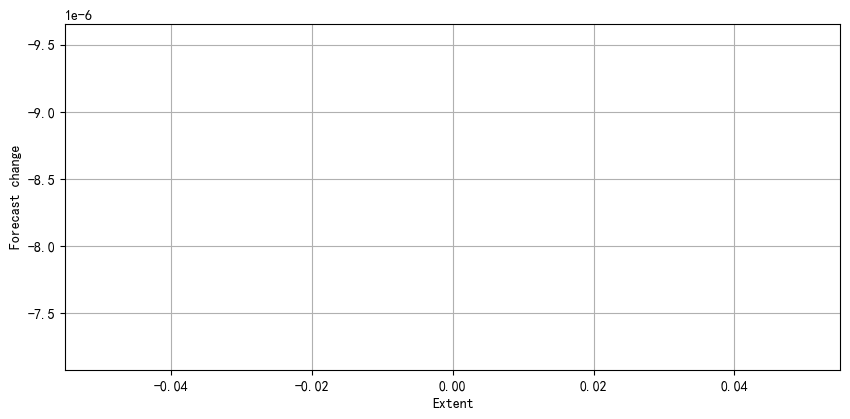

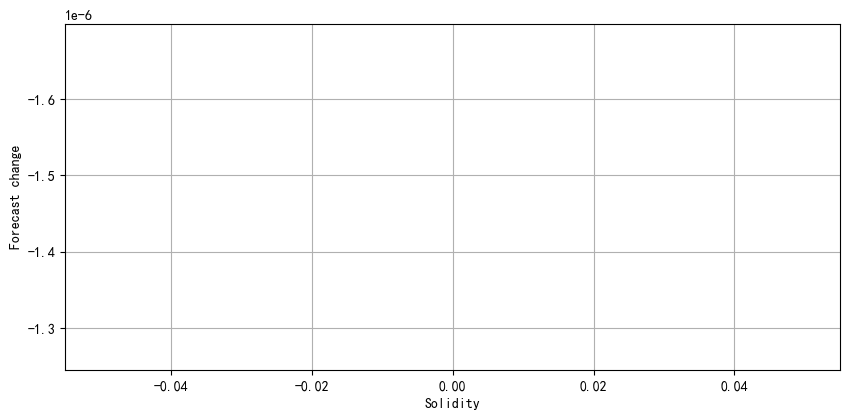

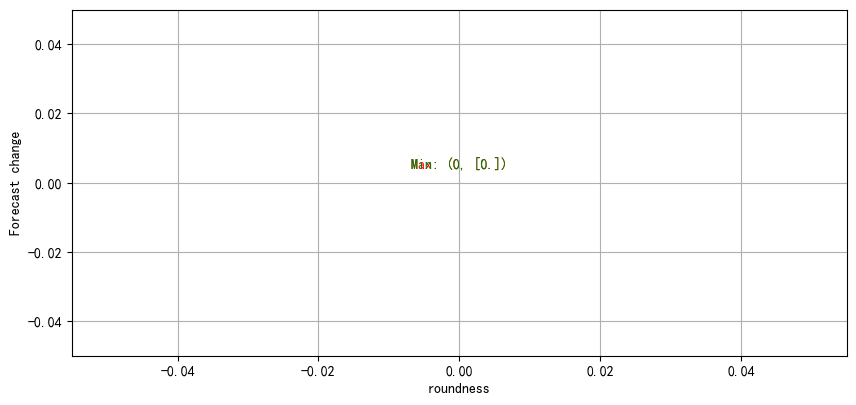

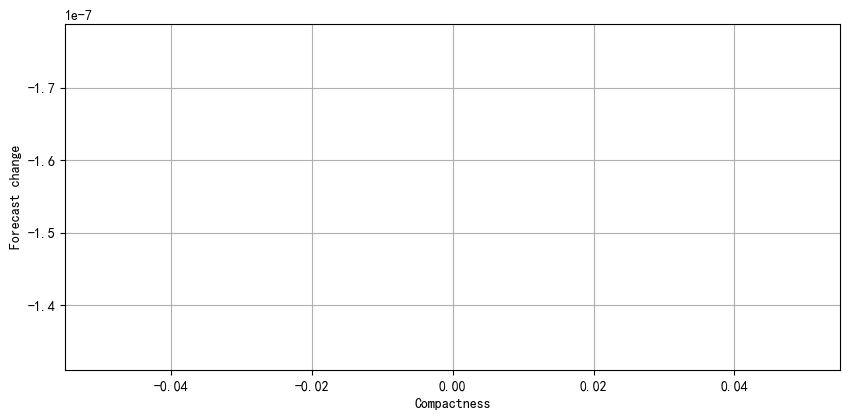

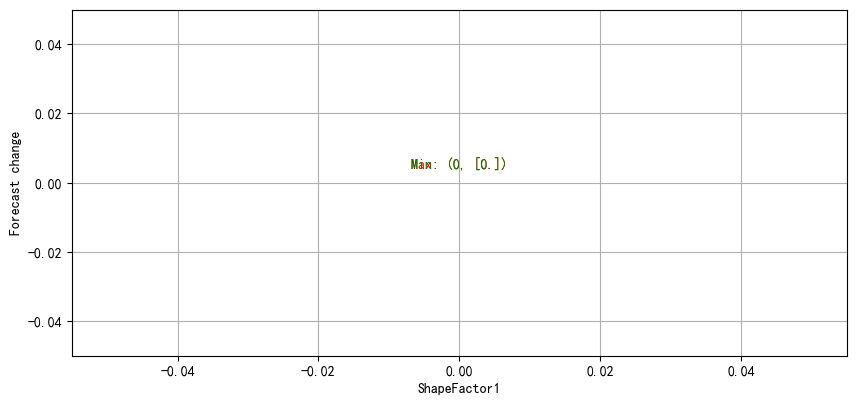

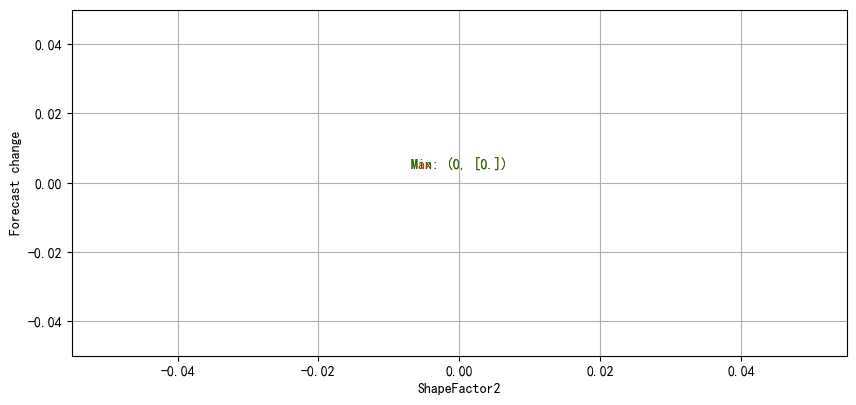

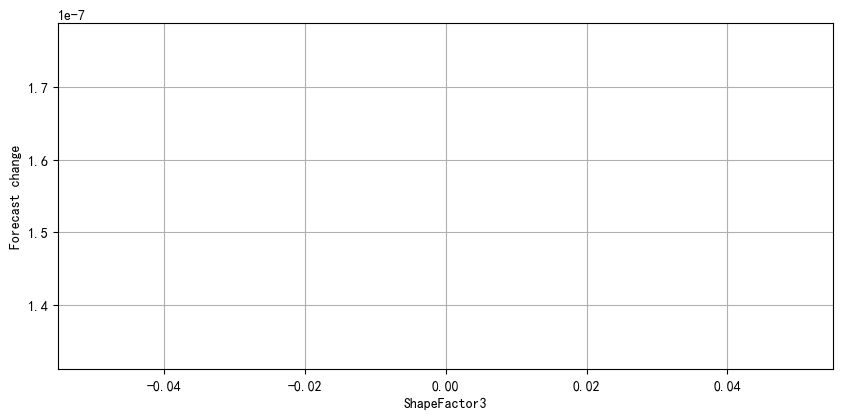

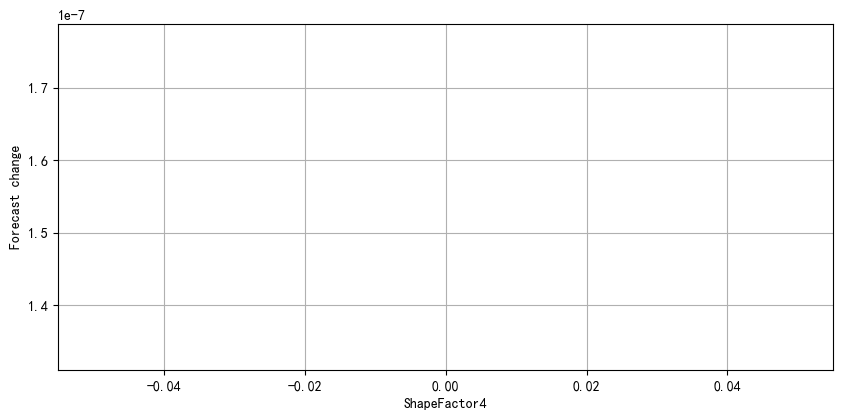

In [4]:
max_values_cnn_lstm = []
for test in [8,2301,3780,3907,5820,7721,10241]:
    test_row = test
    x, y = df.iloc[test_row,1:-1], df.iloc[test_row,-1]
    x = x.values.reshape(1,x.shape[0],1)
    x = tf.convert_to_tensor(x,dtype=tf.float32)
    init_val = model.predict(x)
    min_value_list,max_value_list,values_count_list,values_range_list = value_range(column_names,df)
    x_list = Disturbance_range(column_names,min_value_list,max_value_list,values_count_list)
    y_list = Fresh_breeze(x,column_names,min_value_list,max_value_list,values_count_list,init_val)
    max_values = visualization(column_names,y_list)
    max_values_cnn_lstm.append(max_values)
max_values_list_new = []
for i in max_values_cnn_lstm:
    max_values_list_new.append(np.concatenate(i))
max_values = np.maximum.reduce(max_values_list_new)

In [8]:
target_variable_list

['Perimeter - target_variable: -0.35',
 'MajorAxisLength - target_variable: -0.34',
 'MinorAxisLength - target_variable: -0.30',
 'AspectRation - target_variable: -0.16',
 'Eccentricity - target_variable: -0.16',
 'ConvexArea - target_variable: -0.34',
 'EquivDiameter - target_variable: -0.34',
 'Extent - target_variable: -0.03',
 'Solidity - target_variable: 0.32',
 'roundness - target_variable: 0.34',
 'Compactness - target_variable: 0.16',
 'ShapeFactor1 - target_variable: 0.30',
 'ShapeFactor2 - target_variable: 0.31',
 'ShapeFactor3 - target_variable: 0.16',
 'ShapeFactor4 - target_variable: 0.21']

In [5]:
max_values

array([1.3072193e-02, 9.9621844e-01, 9.9662220e-01, 9.9375331e-01,
       9.7763729e-01, 9.8894423e-01, 9.9588400e-01, 4.9319869e-01,
       1.9228166e-01, 1.9576728e-01, 1.2083006e-01, 6.8372488e-04,
       1.1044741e-04, 1.7719269e-02, 7.3888898e-03], dtype=float32)

In [9]:
F_imp_remove1 = ['Perimeter','Extent','Solidity','Compactness','roundness','ShapeFactor1','ShapeFactor2','ShapeFactor3','ShapeFactor4']

In [10]:
F_cor_remove1 = ['AspectRation','Eccentricity','Extent','Compactness','ShapeFactor3','ShapeFactor4']

In [11]:
df = pd.read_csv("Dataset\\test.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
columns_to_drop = F_imp_remove1
df_dropped = x.drop(columns=columns_to_drop)
x = df_dropped

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1],1))
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.values.reshape(len(y_train), 1))
y_test = onehot.fit_transform(y_test.values.reshape(len(y_test), 1))

In [13]:
inp=Input(shape=(x_train.shape[1:]))
x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)

lstm1=LSTM(units=32,activation='tanh',return_sequences=True)(inp)
l=Dropout(0.5)(lstm1)
l=LSTM(units=64,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
l=LSTM(units=128,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
d = Flatten()(l)

g2=concatenate([g,d],axis=1)
q = Dense(128)(g2)
q = LeakyReLU(alpha=0.33)(q)
q = Dense(256, activation="tanh")(q)
output = Dense(7, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(q)
model = Model(inputs=inp,outputs=output)

In [14]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),  #优化器
              loss = 'categorical_crossentropy', #损失函数
              metrics = ['accuracy']
             )
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.5,min_lr=0.000001)

In [15]:
start = time.perf_counter()
history = model.fit(x_train,
                    y_train,
                    epochs=40,
                    callbacks = [lr_reduce],
                    batch_size= 32,
                    validation_data = (x_test,y_test),
                    shuffle=True)
end = time.perf_counter()

Epoch 1/40
621/621 [==============================] - 29s 30ms/step - loss: 1.3617 - accuracy: 0.5058 - val_loss: 0.4899 - val_accuracy: 0.8383
Epoch 2/40
621/621 [==============================] - 13s 21ms/step - loss: 0.5434 - accuracy: 0.8135 - val_loss: 0.3795 - val_accuracy: 0.8743
Epoch 3/40
621/621 [==============================] - 14s 22ms/step - loss: 0.4780 - accuracy: 0.8318 - val_loss: 0.4322 - val_accuracy: 0.8502
Epoch 4/40
621/621 [==============================] - 13s 21ms/step - loss: 0.4853 - accuracy: 0.8216 - val_loss: 0.4083 - val_accuracy: 0.8536
Epoch 5/40
621/621 [==============================] - 13s 21ms/step - loss: 0.4477 - accuracy: 0.8392 - val_loss: 0.4021 - val_accuracy: 0.8522
Epoch 6/40
621/621 [==============================] - 14s 23ms/step - loss: 0.4037 - accuracy: 0.8518 - val_loss: 0.3536 - val_accuracy: 0.8598
Epoch 7/40
621/621 [==============================] - 13s 21ms/step - loss: 0.3961 - accuracy: 0.8537 - val_loss: 0.4150 - val_accuracy:

In [16]:
print(model.evaluate(x_test,y_test))
print('Running time: %s Seconds'%(end-start))
Y_test = np.argmax(y_test, axis=1)# Convert one-hot to index
from sklearn.metrics import classification_report
predict = model.predict(x_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,digits=5))

156/156 [==============================] - 1s 7ms/step - loss: 0.3088 - accuracy: 0.8798
[0.30877599120140076, 0.8797582983970642]
Running time: 531.8810274999998 Seconds
              precision    recall  f1-score   support

           0    0.82786   0.71777   0.76890       737
           1    1.00000   1.00000   1.00000       686
           2    0.74629   0.84572   0.79290       713
           3    0.91134   0.86008   0.88497       729
           4    0.96465   0.92514   0.94448       708
           5    0.94798   0.94798   0.94798       692
           6    0.79172   0.87429   0.83096       700

    accuracy                        0.87976      4965
   macro avg    0.88426   0.88157   0.88145      4965
weighted avg    0.88334   0.87976   0.88006      4965



In [17]:
df = pd.read_csv("Dataset\\test.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
columns_to_drop = F_cor_remove1
df_dropped = x.drop(columns=columns_to_drop)
x = df_dropped

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1],1))
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.values.reshape(len(y_train), 1))
y_test = onehot.fit_transform(y_test.values.reshape(len(y_test), 1))

In [19]:
x_train.shape

(19857, 9, 1)

In [20]:
inp=Input(shape=(x_train.shape[1:]))
x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)

lstm1=LSTM(units=32,activation='tanh',return_sequences=True)(inp)
l=Dropout(0.5)(lstm1)
l=LSTM(units=64,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
l=LSTM(units=128,activation='tanh',return_sequences=True)(l)
l=Dropout(0.5)(l)
d = Flatten()(l)

g2=concatenate([g,d],axis=1)
q = Dense(128)(g2)
q = LeakyReLU(alpha=0.33)(q)
q = Dense(256, activation="tanh")(q)
output = Dense(7, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(q)
model = Model(inputs=inp,outputs=output)

In [21]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),  #优化器
              loss = 'categorical_crossentropy', #损失函数
              metrics = ['accuracy']
             )
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.5,min_lr=0.000001)

In [22]:
start = time.perf_counter()
history = model.fit(x_train,
                    y_train,
                    epochs=40,
                    callbacks = [lr_reduce],
                    batch_size= 32,
                    validation_data = (x_test,y_test),
                    shuffle=True)
end = time.perf_counter()

Epoch 1/40
621/621 [==============================] - 21s 28ms/step - loss: 1.7397 - accuracy: 0.3077 - val_loss: 0.9237 - val_accuracy: 0.5726
Epoch 2/40
621/621 [==============================] - 15s 25ms/step - loss: 1.0209 - accuracy: 0.5356 - val_loss: 0.8690 - val_accuracy: 0.5809
Epoch 3/40
621/621 [==============================] - 15s 24ms/step - loss: 0.9130 - accuracy: 0.5798 - val_loss: 0.7731 - val_accuracy: 0.6421
Epoch 4/40
621/621 [==============================] - 15s 24ms/step - loss: 0.8274 - accuracy: 0.6244 - val_loss: 0.6853 - val_accuracy: 0.7144
Epoch 5/40
621/621 [==============================] - 15s 24ms/step - loss: 0.7583 - accuracy: 0.6680 - val_loss: 0.5907 - val_accuracy: 0.7384
Epoch 6/40
621/621 [==============================] - 15s 24ms/step - loss: 0.7030 - accuracy: 0.7011 - val_loss: 0.5048 - val_accuracy: 0.8006
Epoch 7/40
621/621 [==============================] - 15s 24ms/step - loss: 0.6497 - accuracy: 0.7229 - val_loss: 0.6359 - val_accuracy:

In [23]:
print(model.evaluate(x_test,y_test))
print('Running time: %s Seconds'%(end-start))
Y_test = np.argmax(y_test, axis=1)# Convert one-hot to index
from sklearn.metrics import classification_report
predict = model.predict(x_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,digits=5))

156/156 [==============================] - 1s 8ms/step - loss: 0.2673 - accuracy: 0.9047
[0.2673207223415375, 0.9047331213951111]
Running time: 608.5237947 Seconds
              precision    recall  f1-score   support

           0    0.93023   0.81411   0.86831       737
           1    1.00000   1.00000   1.00000       686
           2    0.83760   0.91865   0.87625       713
           3    0.89569   0.88340   0.88950       729
           4    0.94964   0.93220   0.94084       708
           5    0.93581   0.94798   0.94185       692
           6    0.80190   0.84429   0.82255       700

    accuracy                        0.90473      4965
   macro avg    0.90727   0.90580   0.90561      4965
weighted avg    0.90695   0.90473   0.90490      4965



# 实验2

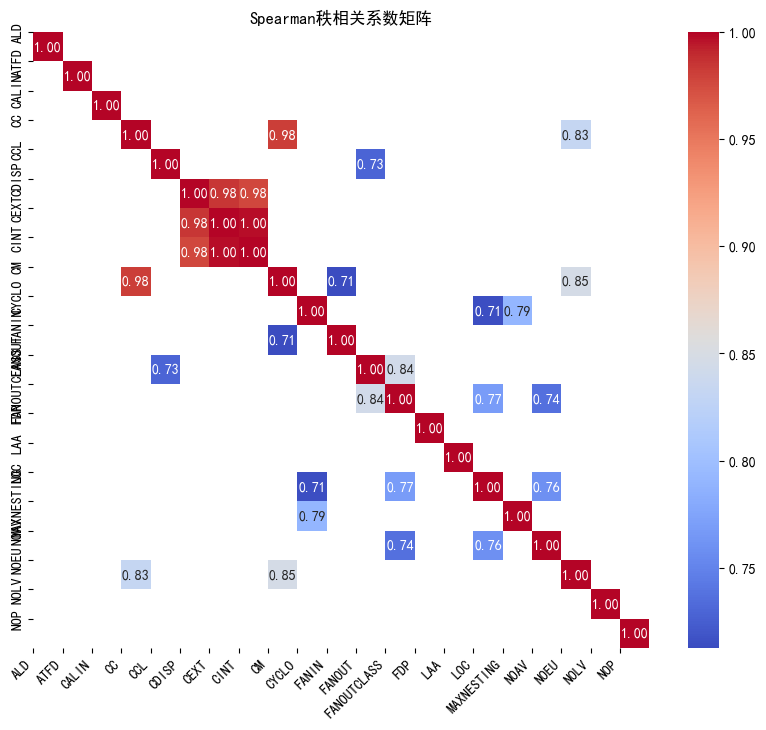

In [24]:
model = load_model('test_model\BM_new_CNN_LSTM.h5')#加载CNN模型
df = pd.read_csv("Dataset\BM.csv",encoding="gbk")
column_names = df.columns[1:-1].tolist()
feature_dict = {}
spearmanr_data = df.iloc[:,1:-1]
feature_dict = set_feature_dict(column_names,feature_dict)
rela_class,feature_dict,feature_correlation_list = Feature_correlation_analysis(column_names,feature_dict,spearmanr_data)
target_variable = df['is_brain']
column_names = df.columns[1:-1]
feature_dict,target_variable_list = target_correlation_analysis(feature_dict,target_variable,column_names)

In [25]:
target_variable_list

['ALD - target_variable: 0.13',
 'ATFD - target_variable: 0.17',
 'CALIN - target_variable: 0.14',
 'CC - target_variable: 0.04',
 'CCL - target_variable: 0.10',
 'CDISP - target_variable: 0.07',
 'CEXT - target_variable: 0.17',
 'CINT - target_variable: 0.18',
 'CM - target_variable: 0.05',
 'CYCLO - target_variable: 0.30',
 'FANIN - target_variable: 0.07',
 'FANOUT - target_variable: 0.28',
 'FANOUTCLASS - target_variable: 0.19',
 'FDP - target_variable: 0.36',
 'LAA - target_variable: 0.22',
 'LOC - target_variable: 0.19',
 'MAXNESTING - target_variable: 0.49',
 'NOAV - target_variable: 0.17',
 'NOEU - target_variable: 0.07',
 'NOLV - target_variable: 0.25',
 'NOP - target_variable: 0.21']

Running time: 216.1004743999997 Seconds


C:\Users\liang\AppData\Local\Temp\ipykernel_19744\3054686753.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,80))


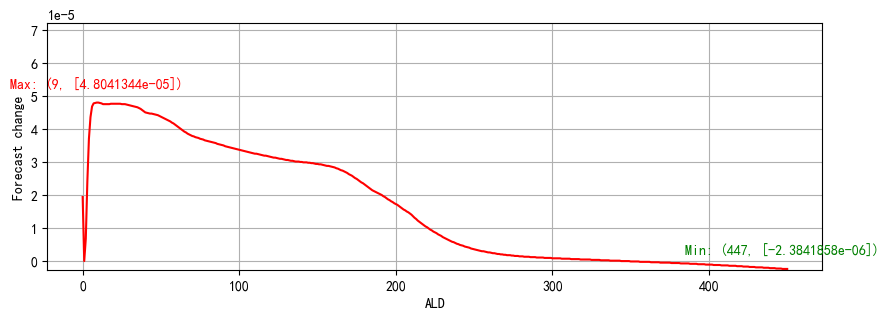

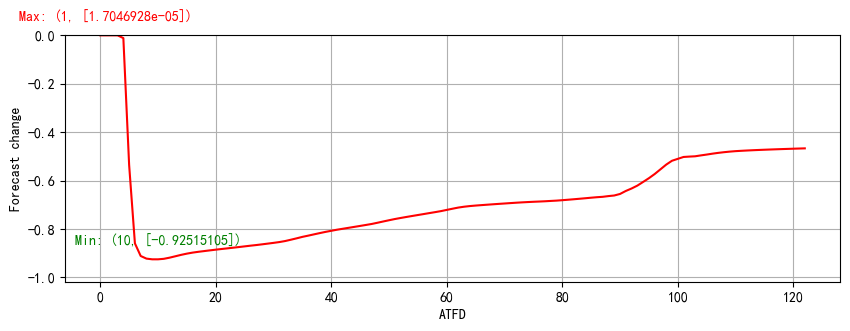

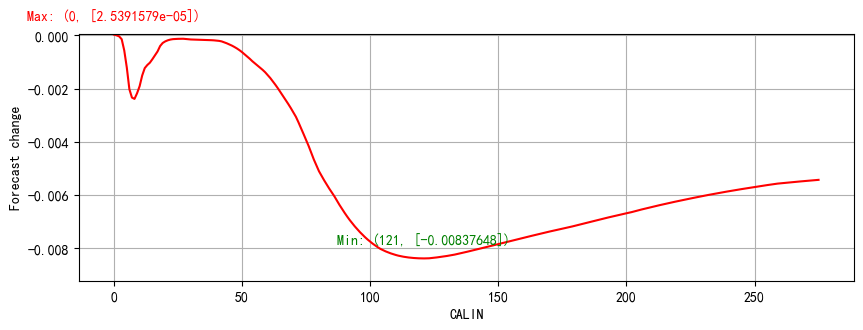

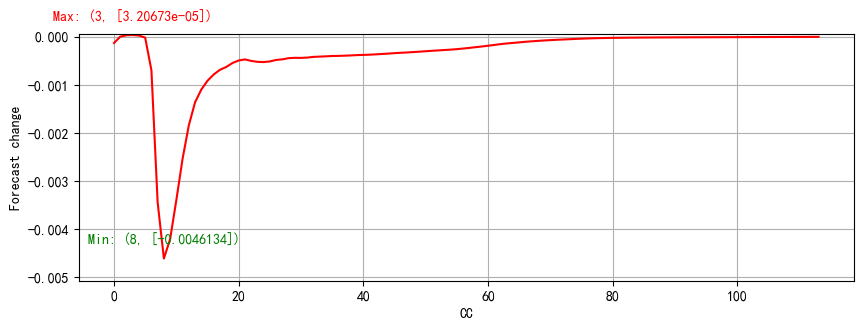

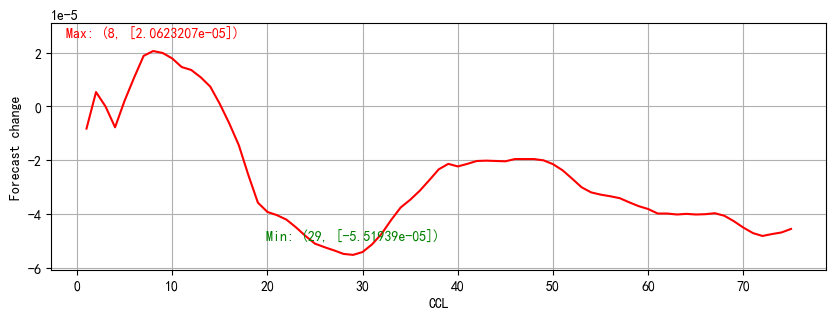

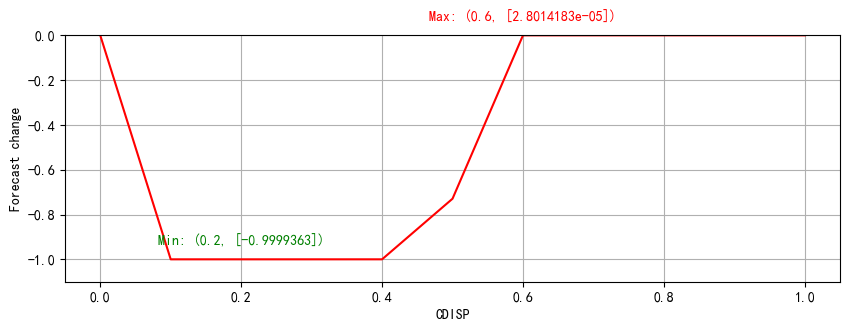

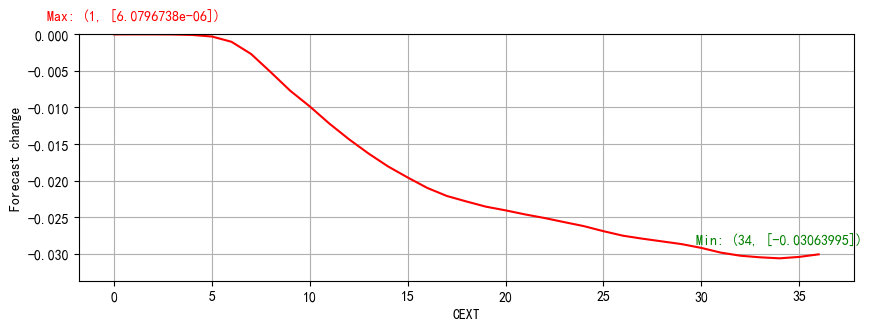

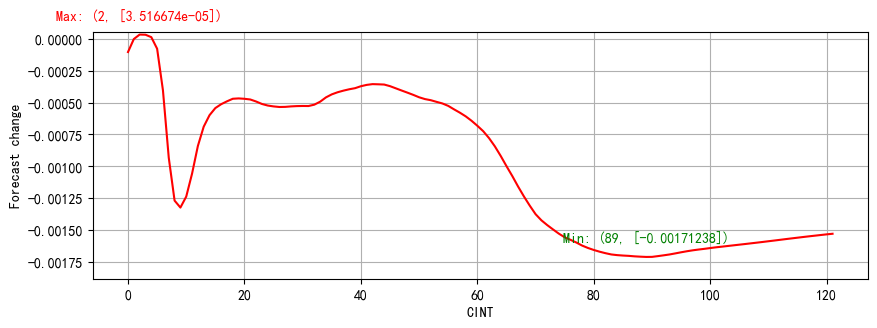

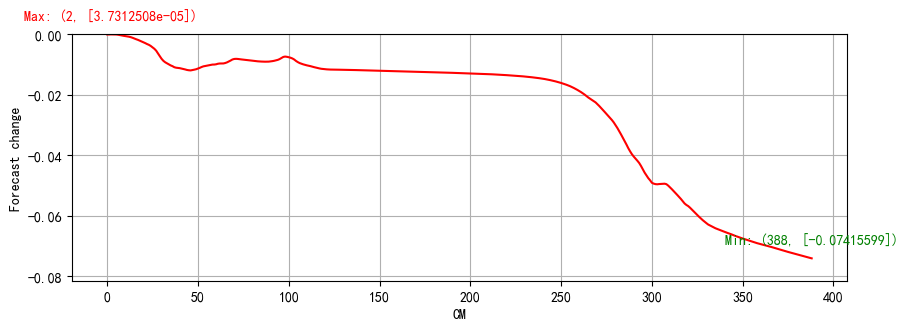

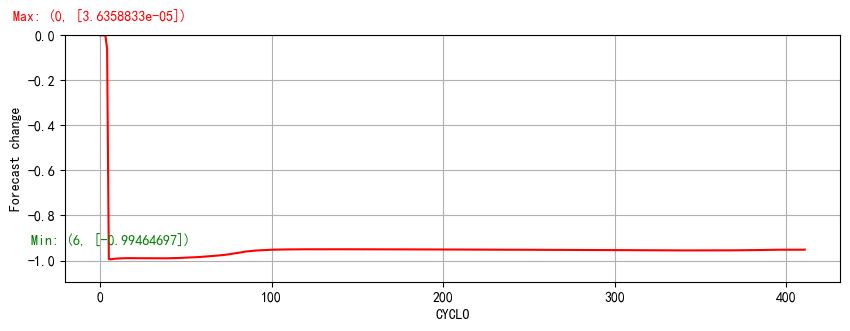

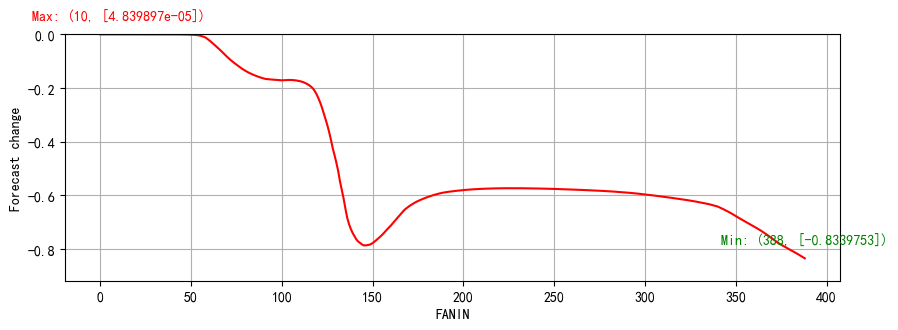

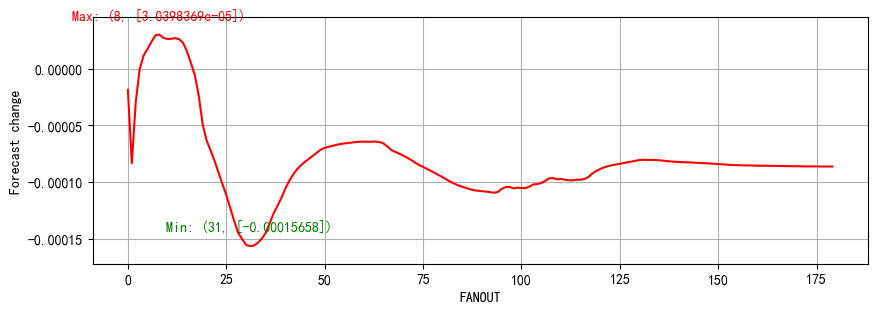

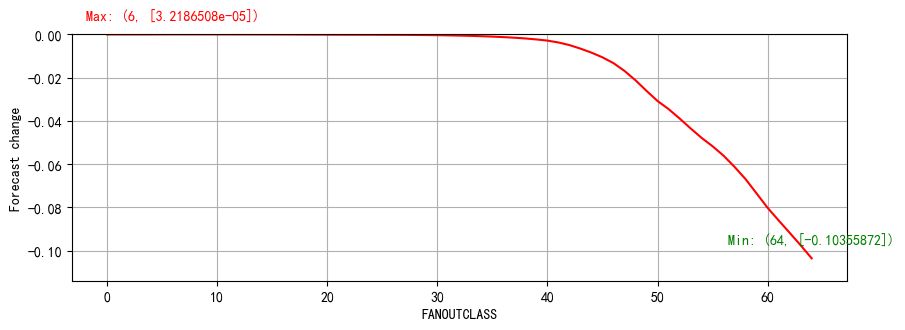

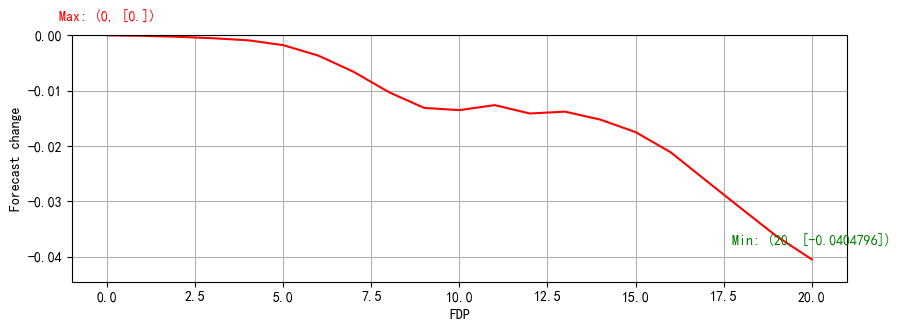

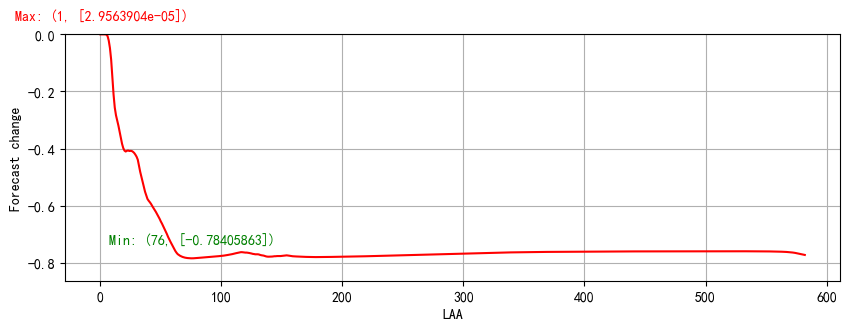

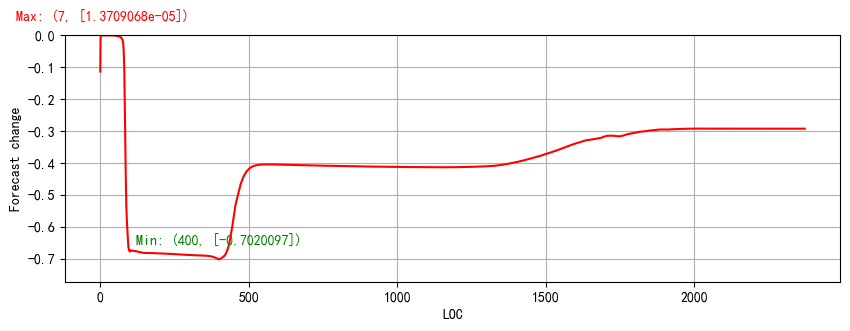

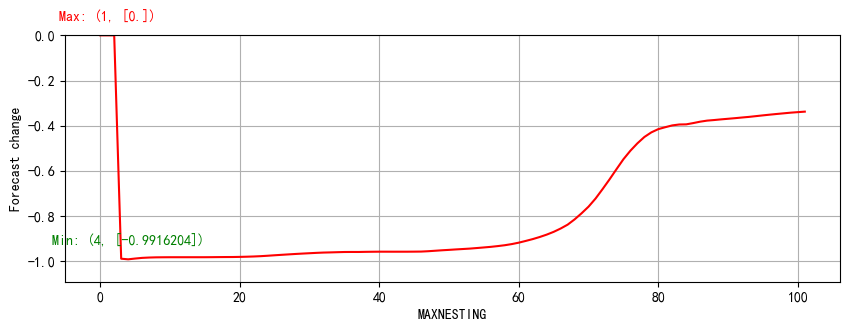

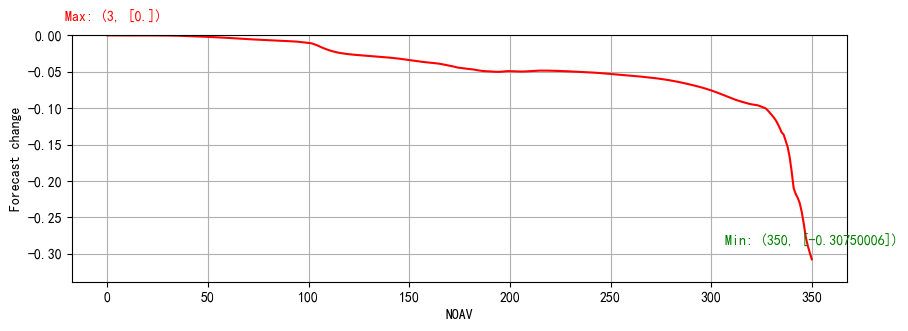

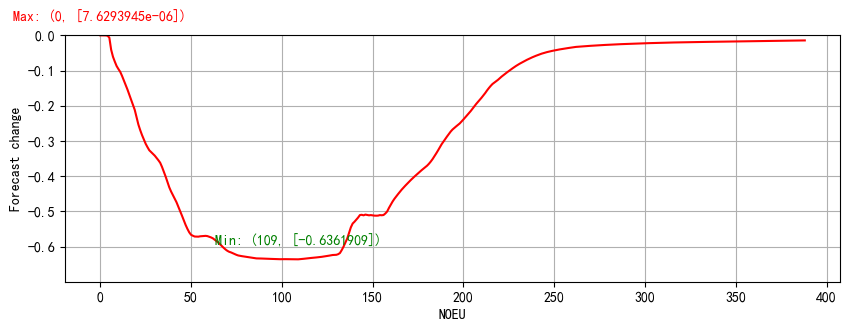

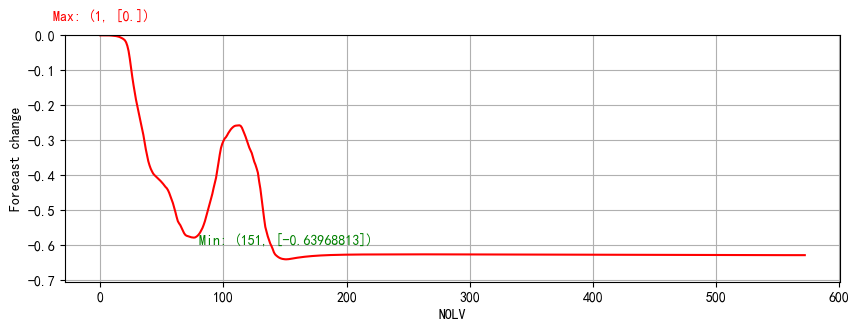

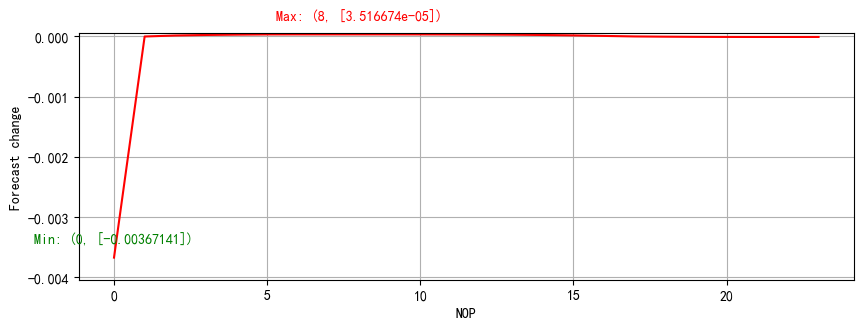

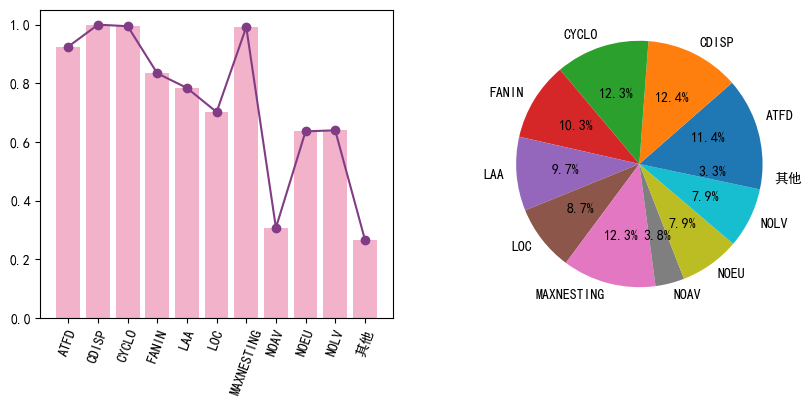

In [26]:
df = pd.read_csv("Dataset\BM.csv",encoding="gbk")
base = df.iloc[:,1:-1]
base_data = base.mean()
base_data = base_data.round().astype(int)
base_data = base_data.values.reshape(1,base_data.shape[0],1)
x = base_data
x = tf.convert_to_tensor(x,dtype=tf.float32)
init_val = model.predict(x)
min_value_list,max_value_list,values_count_list,values_range_list = value_range(column_names,df)
x_list = Disturbance_range(column_names,min_value_list,max_value_list,values_count_list)
y_list = Fresh_breeze(x,column_names,min_value_list,max_value_list,values_count_list,init_val)
max_values = visualization(column_names,y_list)
threshold = 2
feature_important(column_names,threshold,max_values)

In [2]:
F_imp_remove1 = ['ALD','CALIN','CC','CCL','CEXT','CINT','CM','FANOUT','FANOUTCLASS','FDP','NOP','NOAV']
F_cor_remove1 = ['ALD','ATFD','CALIN','CC','CCL','CDISP','CINT','CEXT','CM','FANIN','FANOUTCLASS','LAA','NOAV','NOEU','NOP','LOC','NOLV']

In [3]:
df = pd.read_csv("Dataset\\BM.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
columns_to_drop = F_imp_remove1
df_dropped = x.drop(columns=columns_to_drop)
x = df_dropped
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1],1))
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.values.reshape(len(y_train), 1))
y_test = onehot.fit_transform(y_test.values.reshape(len(y_test), 1))
print(x_train.shape)

(121715, 9, 1)


In [4]:
inp=Input(shape=(x_train.shape[1:]))
x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)
lstm1=LSTM(units=32,activation='tanh',return_sequences=True)(inp)
l=Dropout(0.5)(lstm1)
l=Dense(64,activation="relu")(l)
l=Dropout(0.5)(l)
l=Dense(128,activation="relu")(l)
l=Dropout(0.5)(l)
d = Flatten()(l)
g2=concatenate([g,d],axis=1)
output = Dense(2, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(g2)
model = Model(inputs=inp,outputs=output)

In [5]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),  #优化器
              loss = 'categorical_crossentropy', #损失函数
              metrics = ['accuracy']
             )
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.5,min_lr=0.000001)

In [6]:
start = time.perf_counter()
history = model.fit(x_train,
                    y_train,
                    epochs=30,
                    callbacks = [lr_reduce],
                    batch_size= 32,
                    validation_data = (x_test,y_test),
                    shuffle=True)
end = time.perf_counter()
print(model.evaluate(x_test,y_test))
print('Running time: %s Seconds'%(end-start))
Y_test = np.argmax(y_test, axis=1)# Convert one-hot to index
from sklearn.metrics import classification_report
predict = model.predict(x_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,digits=5))

Epoch 1/30
3804/3804 [==============================] - 69s 17ms/step - loss: 0.3836 - accuracy: 0.8920 - val_loss: 0.2429 - val_accuracy: 0.9119
Epoch 2/30
3804/3804 [==============================] - 66s 17ms/step - loss: 0.2303 - accuracy: 0.9210 - val_loss: 0.2191 - val_accuracy: 0.9273
Epoch 3/30
3804/3804 [==============================] - 63s 17ms/step - loss: 0.2256 - accuracy: 0.9214 - val_loss: 0.2129 - val_accuracy: 0.9283
Epoch 4/30
3804/3804 [==============================] - 63s 17ms/step - loss: 0.2198 - accuracy: 0.9232 - val_loss: 0.2114 - val_accuracy: 0.9279
Epoch 5/30
3804/3804 [==============================] - 63s 17ms/step - loss: 0.2161 - accuracy: 0.9245 - val_loss: 0.2075 - val_accuracy: 0.9290
Epoch 6/30
3804/3804 [==============================] - 63s 16ms/step - loss: 0.2143 - accuracy: 0.9252 - val_loss: 0.2082 - val_accuracy: 0.9275
Epoch 7/30
3804/3804 [==============================] - 67s 18ms/step - loss: 0.2118 - accuracy: 0.9257 - val_loss: 0.2040 -

In [7]:
df = pd.read_csv("Dataset\\BM.csv",encoding="gbk")
x, y = df.iloc[:, 1:-1], df.iloc[:, -1]
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
columns_to_drop = F_cor_remove1
df_dropped = x.drop(columns=columns_to_drop)
x = df_dropped
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1],1))
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train.values.reshape(len(y_train), 1))
y_test = onehot.fit_transform(y_test.values.reshape(len(y_test), 1))
print(x_train.shape)

(121715, 4, 1)


In [8]:
inp=Input(shape=(x_train.shape[1:]))
x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)
lstm1=LSTM(units=32,activation='tanh',return_sequences=True)(inp)
l=Dropout(0.5)(lstm1)
l=Dense(64,activation="relu")(l)
l=Dropout(0.5)(l)
l=Dense(128,activation="relu")(l)
l=Dropout(0.5)(l)
d = Flatten()(l)
g2=concatenate([g,d],axis=1)
output = Dense(2, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(g2)
model = Model(inputs=inp,outputs=output)

In [9]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),  #优化器
              loss = 'categorical_crossentropy', #损失函数
              metrics = ['accuracy']
             )
lr_reduce=keras.callbacks.ReduceLROnPlateau('val_loss',patience=3,factor=0.5,min_lr=0.000001)

In [10]:
start = time.perf_counter()
history = model.fit(x_train,
                    y_train,
                    epochs=30,
                    callbacks = [lr_reduce],
                    batch_size= 32,
                    validation_data = (x_test,y_test),
                    shuffle=True)
end = time.perf_counter()
print(model.evaluate(x_test,y_test))
print('Running time: %s Seconds'%(end-start))
Y_test = np.argmax(y_test, axis=1)# Convert one-hot to index
from sklearn.metrics import classification_report
predict = model.predict(x_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,digits=5))

Epoch 1/30
3804/3804 [==============================] - 63s 16ms/step - loss: 0.4877 - accuracy: 0.8491 - val_loss: 0.3542 - val_accuracy: 0.8776
Epoch 2/30
3804/3804 [==============================] - 60s 16ms/step - loss: 0.3635 - accuracy: 0.8742 - val_loss: 0.3463 - val_accuracy: 0.8831
Epoch 3/30
3804/3804 [==============================] - 60s 16ms/step - loss: 0.3502 - accuracy: 0.8790 - val_loss: 0.3364 - val_accuracy: 0.8836
Epoch 4/30
3804/3804 [==============================] - 60s 16ms/step - loss: 0.3448 - accuracy: 0.8806 - val_loss: 0.3278 - val_accuracy: 0.8867
Epoch 5/30
3804/3804 [==============================] - 61s 16ms/step - loss: 0.3401 - accuracy: 0.8825 - val_loss: 0.3352 - val_accuracy: 0.8870
Epoch 6/30
3804/3804 [==============================] - 61s 16ms/step - loss: 0.3389 - accuracy: 0.8826 - val_loss: 0.3247 - val_accuracy: 0.8881
Epoch 7/30
3804/3804 [==============================] - 62s 16ms/step - loss: 0.3359 - accuracy: 0.8840 - val_loss: 0.3333 -